In [1]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import missingno as msno
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,r2_score
from hyperopt import fmin, tpe, hp, Trials
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)
plt.style.use("ggplot")
sns.set_palette(sns.diverging_palette(220, 20))

# Uçuş Rötarları ve İptallerinin Analizi
---

### Proje Detayları
- Time Series Analysis and Forecasting için tarih-saat oluşturulmalıdır, böylece çizim ve zaman serisi analizi daha etkili bir şekilde gerçekleştirilebilir.
- Kalkış ve varış saatleri düzeltilmelidir, bu sayede verilerin doğruluğu sağlanabilir.
- Kopyalar kontrol edilmelidir, böylece veri setinde tutarsızlıklar ve tekrarlanan bilgiler tespit edilebilir.
- HAVA DURUMU DEĞİŞKENLERİ İLE, DELAY ARASINDA MANTIKLI BİR PARAMETRE VAR MI?

### Beklenenler
- csv dosyasındaki verileri düzenleyiniz.
- Gecikmeler açısından hangi havayolları en kötü performansı gösteriyor?
- Hangisi en iyisi?
- Uçuş performansı yılın aylarına göre değişiyor mu? Bir havayolu şirketi her zaman en kötü performansı gösteren havayolu mudur, yoksa değişkenlik var mıdır?
- Hangi rotaların 1. seviye gecikme sınıfına girme olasılığı en yüksek?


<span style="color: green"> Gecikme sürelerini cut veya qcut fonksiyonları ile 5 parçaya bölerek kategorik bir değişken oluşturunuz.</span>

<span style="color: green">Örneğin: En az gecikme 1. Seviye, en çok gecikme 5. seviye olmak üzere</span>


---
# PROJE SORULARI
---
1.	Her havayolunun mesafeyle ilişkisini anlamak için kategorik bir değişken oluşturunuz.
2.	Uçuş mesafeleri, 500 mil altındaki mesafeler, 500-1000 mil arasındaki mesafeler ve 1000 mil ve üzerindeki mesafeler olmak üzere üç ana grupta sınıflandırınız.
3.	Havayolu şirketleri arasında en fazla uçuşu gerçekleştiren firmaları belirleyiniz.
4.	Gecikmeleri varsayarak havayolu şirketlerinin performansları kıyaslayınız.
5.	Havayolu performansının yılın farklı aylarına göre değişip değişmediğini ve en iyi 5 havayolu performansı ile en kötü 5 performansı gösteriniz.
6.	Uçuş iptallerinin yüzde kaç olduğunu belirleyip havayoluna göre değişkenliğini gösteriniz?
7.	Rotar Süresinin daha yüksek olduğu günün belirli bir saati ve/veya yılın saati var mı?
8.	En yüksek ROTAR(gecikme) süresine sahip güzergahlar hangileri?
9.	Makine öğrenmesi modeli kurup uçuşların gecikme sürelerini tahmin ediniz.
10.	Modeli Değerlendiriniz.



# Veri Doğrulama

Veri setinde 111006 satır ve 29 değişken bulunmaktadır. 2 havaalanından kalkan uçakların 2022 yılına ait ilk 6 aylık verisinden oluşur.

Değişken açıklamaları:

- year : Yıl - 2022 yılına ait verileri kapsar.
- month: Ay - 1. ve 6. aya ait verileri kapsar.
- day: Gün - 31 günü ifade eder.
- dep_time: Uçağın gerçekleşen kalkış zamanıdır. 
- sched_dep_time: Planlanan kalkış zamanı
- dep_delay: Kalkış gecikme süresi
- arr_time: Gerçekleşen varış zamanı
- sched_arr_time: Planlanan varış zamanı
- arr_delay: Varış gecikme süresi
- carrier: Hava yolu şirketinin kısaltması
- flight: uçuş numarası ?
- tailnum: Uçak kuyruk numarası
- origin: kalkış hava alanı kodu (SEA ve PDX)
- dest: varış hava alanı kodu (97 adet havaalanı bulunmaktadır)
- air_time: Uçuş süresi
- distance: Uçuş mesafesi
- hour: Saat
- Minute: Dakika
- airline: Havayolu şirketinin adı
- route: Uçuş rotası
- temp: Sıcaklık
- dewp: Çiy noktası sıcaklığı, bir hava kütlesinin içindeki su buharının yoğunlaşmaya başladığı sıcaklık.
- humid: Nemlilik
- wind_dir: Rüzgar yönü
- wind_speed: Rüzgar hızı
- wind_gust:  belirli bir zaman dilimindeki rüzgarın en yüksek hızını ifade eder
- precip: Yağış
- pressure: Hava basıncı
- visib: Görüş mesafesi

In [2]:
df = pd.read_csv("data/flights_weather2022.csv")

In [3]:
df.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,airline,route,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib
0,2022,1,1,1.0,2359,2.0,604.0,618,-14.0,UA,555,N405UA,SEA,IAH,221.0,1874,23,59,United Air Lines Inc.,SEA-IAH,33.0,23.0,66.06,160.0,8.05546,9.270062,0.0,1022.9,10.0
1,2022,1,1,1.0,2250,71.0,242.0,142,60.0,AS,72,N265AK,SEA,FAI,193.0,1533,22,50,Alaska Airlines Inc.,SEA-FAI,32.0,23.0,69.04,170.0,9.20624,10.594357,0.0,1023.4,10.0
2,2022,1,1,10.0,2355,15.0,759.0,730,29.0,AS,270,N274AK,SEA,ATL,261.0,2182,23,55,Alaska Airlines Inc.,SEA-ATL,33.0,23.0,66.06,160.0,8.05546,9.270062,0.0,1022.9,10.0
3,2022,1,1,25.0,2350,35.0,606.0,550,16.0,AS,7,N281AK,SEA,ORD,193.0,1721,23,50,Alaska Airlines Inc.,SEA-ORD,33.0,23.0,66.06,160.0,8.05546,9.270062,0.0,1022.9,10.0
4,2022,1,1,35.0,2349,46.0,616.0,545,31.0,UA,507,N426UA,PDX,ORD,196.0,1739,23,49,United Air Lines Inc.,PDX-ORD,33.0,19.0,55.75,120.0,6.90468,7.945768,0.0,1025.1,10.0


**Veri setinde 111006 satır ve 29 değişken bulunmaktadır.**

In [4]:
df.shape

(111006, 29)

In [5]:
df["year"].value_counts()

year
2022    111006
Name: count, dtype: int64

In [6]:
df["month"].value_counts()

month
6    20491
5    19971
4    18741
3    18306
1    17473
2    16024
Name: count, dtype: int64

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,111006.0,2022.000000,0.000000,2022.00,2022.000000,2022.000000,2022.000000,2022.000000
month,111006.0,3.623264,1.713287,1.00,2.000000,4.000000,5.000000,6.000000
day,111006.0,15.736654,8.723487,1.00,8.000000,16.000000,23.000000,31.000000
dep_time,108566.0,1336.449487,540.664793,1.00,912.000000,1309.000000,1800.000000,2400.000000
sched_dep_time,111006.0,1342.068158,530.610560,2.00,910.000000,1305.000000,1800.000000,2359.000000
dep_delay,108566.0,8.038456,41.687738,-36.00,-5.000000,-2.000000,6.000000,2120.000000
arr_time,108469.0,1467.243636,570.938019,1.00,1055.000000,1520.000000,1917.000000,2400.000000
sched_arr_time,111006.0,1506.330090,546.796862,3.00,1115.000000,1540.000000,1937.000000,2359.000000
arr_delay,108332.0,2.359524,43.088734,-65.00,-14.000000,-5.000000,6.000000,2098.000000
flight,111006.0,433.663856,267.779635,1.00,210.000000,416.000000,644.000000,1100.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111006 entries, 0 to 111005
Data columns (total 29 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   year            111006 non-null  int64  
 1   month           111006 non-null  int64  
 2   day             111006 non-null  int64  
 3   dep_time        108566 non-null  float64
 4   sched_dep_time  111006 non-null  int64  
 5   dep_delay       108566 non-null  float64
 6   arr_time        108469 non-null  float64
 7   sched_arr_time  111006 non-null  int64  
 8   arr_delay       108332 non-null  float64
 9   carrier         111006 non-null  object 
 10  flight          111006 non-null  int64  
 11  tailnum         110877 non-null  object 
 12  origin          111006 non-null  object 
 13  dest            111006 non-null  object 
 14  air_time        108332 non-null  float64
 15  distance        111006 non-null  int64  
 16  hour            111006 non-null  int64  
 17  minute    

**Sayısal Kolonlar**

In [9]:
numeric_df = df.select_dtypes(include=["int64","float64"])
numeric_df.columns

Index(['year', 'month', 'day', 'dep_time', 'sched_dep_time', 'dep_delay',
       'arr_time', 'sched_arr_time', 'arr_delay', 'flight', 'air_time',
       'distance', 'hour', 'minute', 'temp', 'dewp', 'humid', 'wind_dir',
       'wind_speed', 'wind_gust', 'precip', 'pressure', 'visib'],
      dtype='object')

**Kategorik Kolonlar**

In [10]:
categoric_df =df.select_dtypes(include=["object","category"])
categoric_df.columns

Index(['carrier', 'tailnum', 'origin', 'dest', 'airline', 'route'], dtype='object')

**Veri seti Kalkış havaalanı SEA ve PDX olan 2 adet havaalanlarını kapsar. Kalkışların %75'i SEA, %25'i PDX' den yapılmıştır.**

In [11]:
df["origin"].value_counts(normalize=True) * 100

origin
SEA    74.373457
PDX    25.626543
Name: proportion, dtype: float64

**Varış havaalanı 97 adettir.**

In [12]:
df["dest"].nunique()

97

**Eksik verilerin temizlenmesi**
- Veri setinde dep_time, dep_delay, arr_time, arr_delay, air_time değişkenlerinde sistematik meydana gelen eksik veriler vardır. Bunların aynı anda meydana gelmesi uçuş iptallerinden kaynaklı olabilir. Yine tailnum değişkeninde 129 adet eksik veri vardır. Bu eksiklikte diğer eksiklikler ile ilişkilidir. Aynı zamanda wind_dir, wind_speed ve wind_gust değişkenlerinde de eksiklikler yer almakdadır. 


In [13]:
#Eksik veri kontrolü
df.isnull().sum()

year                 0
month                0
day                  0
dep_time          2440
sched_dep_time       0
dep_delay         2440
arr_time          2537
sched_arr_time       0
arr_delay         2674
carrier              0
flight               0
tailnum            129
origin               0
dest                 0
air_time          2674
distance             0
hour                 0
minute               0
airline              0
route                0
temp                 0
dewp                 0
humid                0
wind_dir          3163
wind_speed         279
wind_gust          279
precip               0
pressure             0
visib                0
dtype: int64

<Figure size 600x400 with 0 Axes>

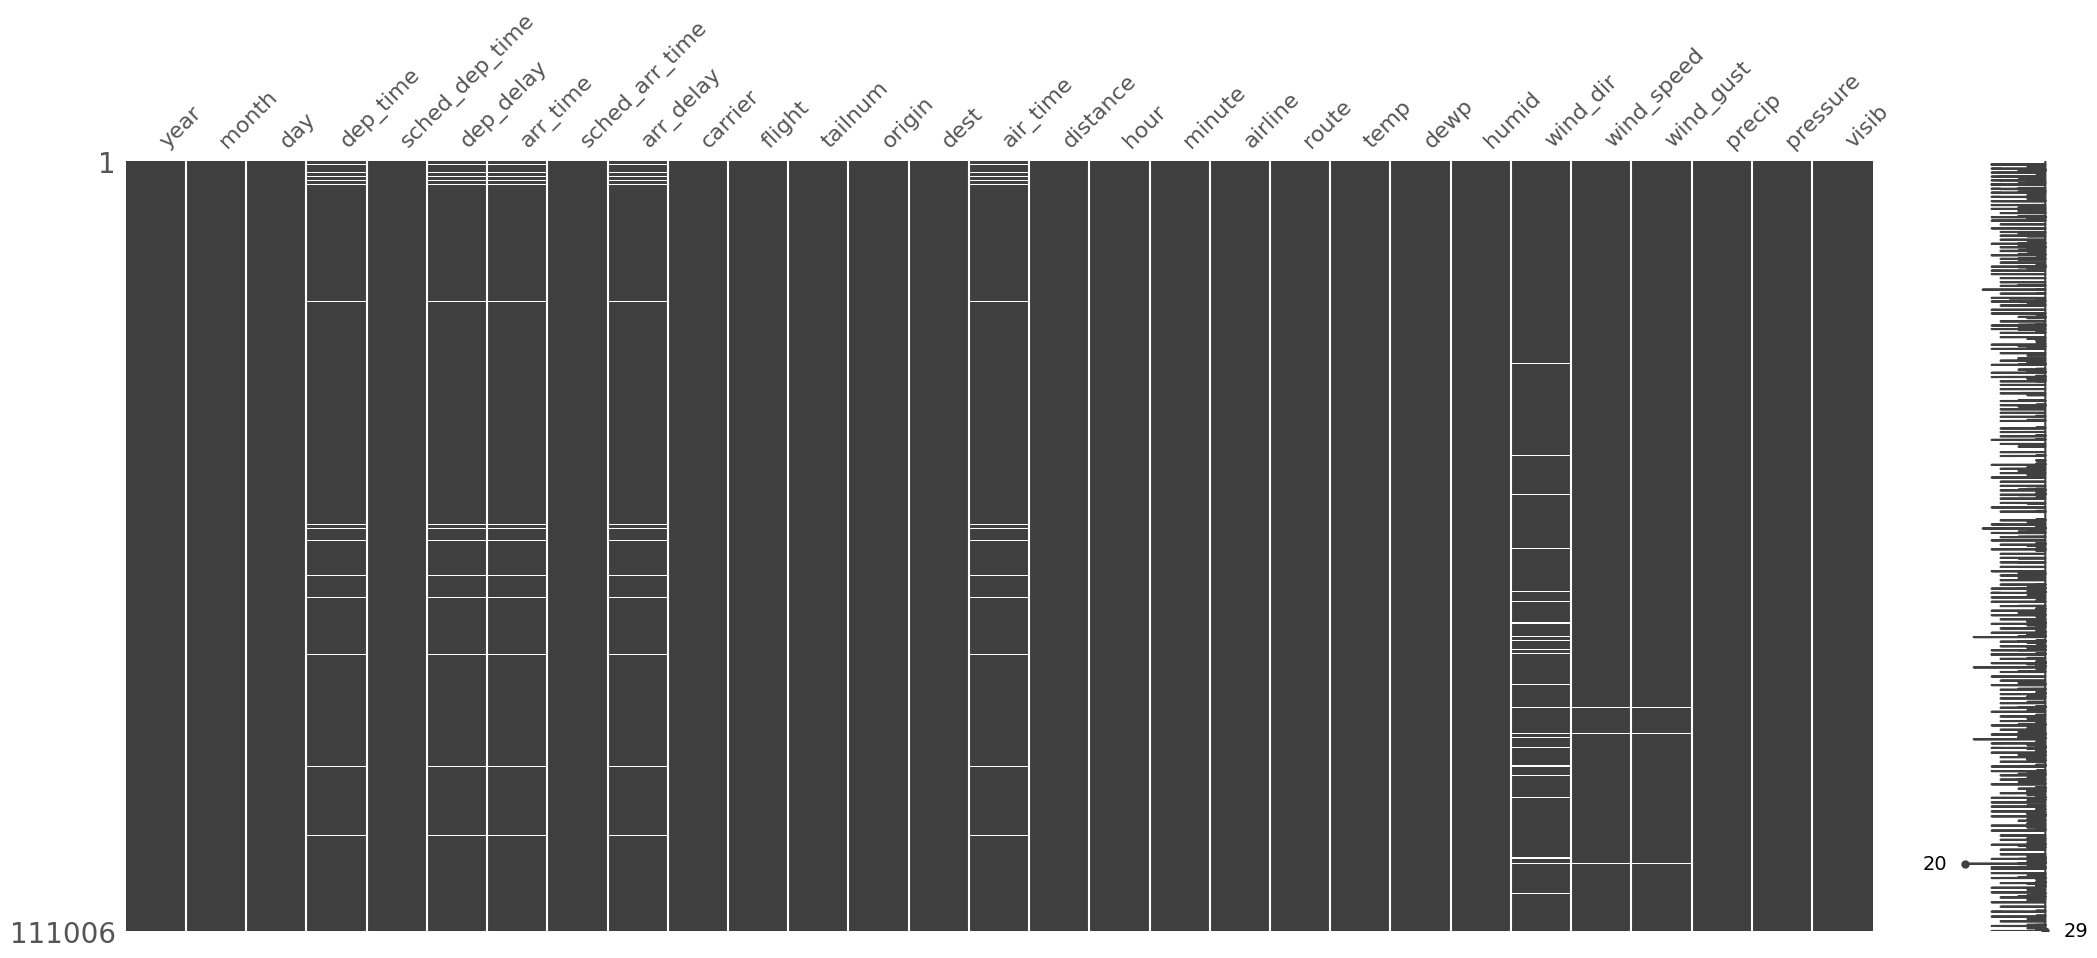

In [14]:
#Eksik verilerin görselleştirilmesi
plt.figure(figsize=(6, 4)) 
msno.matrix(df)
plt.show()

- "dep_time","dep_delay","arr_time","arr_delay","air_time" kolonlarındaki eksik verilerin aynı anda oluşmuş olabileceği grafikten görünüyor. Bu durumu sorguladığımızda bu kolonlarda 2440 değerin eksik olduğu görülmektedir.

In [15]:
df[["dep_time","dep_delay","arr_time","arr_delay","air_time"]].isnull().all(axis=1).sum()


2440

In [16]:
simultaneus_missing_data = df[["dep_time","dep_delay","arr_time","arr_delay","air_time"]].isnull().all(axis=1).sum()
ratio = simultaneus_missing_data / len(df) * 100
print(f"Aynı anda eksik olan değişkenlerin tüm veri setine oranı %{ratio:.2f}'dir.")

Aynı anda eksik olan değişkenlerin tüm veri setine oranı %2.20'dir.


In [17]:
#Eksik değer olan toplam satır sayısı veri setinin yaklaşık %5 ine karşılık gelir.
df.isnull().any(axis=1).sum()

5787

In [18]:
# Genel kabul gören kabul edilebilir eksiklik oranı olan %5'e karşılık gelen veri sayısı 5550 dir. 
#Başka bir deyişle eksik verilerde 5550 adet eksikliğe kadar tölaransımız vardır.
threshold = len(df) * 0.05
threshold

5550.3


**Eksik verileri temizlemeden önce 6. sorunun değerlendirilmesi**

**6.	Uçuş iptallerinin yüzde kaç olduğunu belirleyip havayoluna göre değişkenliğini gösteriniz?**

- "dep_time","dep_delay","arr_time","arr_delay","air_time" kolonlarında 2440 adet aynı anda meydana gelen eksik veriler yer almaktadır. Uçuş iptalini belirten herhangi bir kolon olmadığı için bu eksiklikleri uçuş iptali olarak kabul edilmiştir.
Eksik olan 2440 olan değer veri setinin %2.20'si olduğundan bu sayede uçuş iptallerinin yüzdesini de elde edilmiştir..
- İptaller en çok Alaska Airlines a aittir. Neredeyse toplam iptal edilen uçuşların %50 den fazlasını kapsamaktadır. En az iptal edilen uçuşda Hawaiian Airlines a aittir.

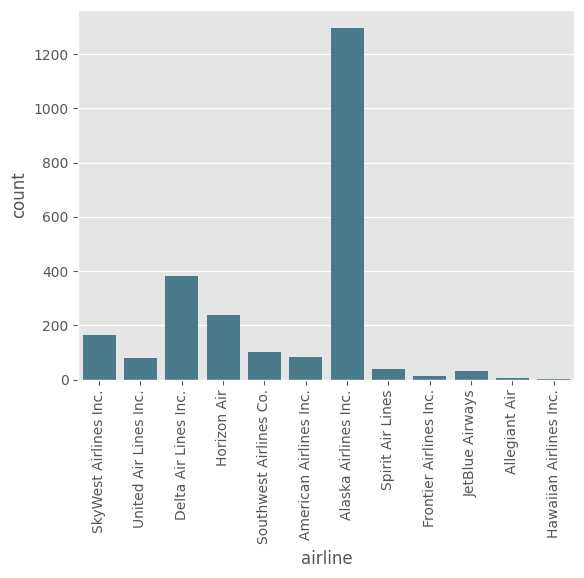

In [19]:
missing_df=df.loc[df[["dep_time","dep_delay","arr_time","arr_delay","air_time"]].isnull().all(axis=1),"airline"].reset_index()
sns.countplot(data=missing_df,x="airline")
plt.xticks(rotation=90)
plt.show()

**Aynı anda eksik olan %2.20 lik verinin veri setinden çıkarılması**

In [20]:
df[["dep_time","dep_delay","arr_time","arr_delay","air_time"]].isnull().all(axis=1).sum()

2440

In [21]:
df.dropna(subset=["dep_time", "dep_delay", "arr_time", "arr_delay", "air_time"], how="all", inplace=True)

-  Bu eksik veriler veri setinin  %2.20 sinde meydana gelmiştir. Genelde kabul gören yaklaşım eksik veriler veri setinin %5'inden fazla değilse silinmesinde sakınca olmayabilir. Ayrıca aynı anda olan eksiklik aynı anda bilgi kaybı demektir. Eksik verileri doldurma yoluna gidersek bir çok değişkeni aynı anda tahmin etmemiz gerekicek buda yanıltıcı sonuçlara yol açabilir.
-  Eksik verilerin aynı olanlarını çıkardıktan sonra arr_time değişkeninde 97 tane arr_delay değişkeninde 234 tane, airtime değişkeninde yine 234 eksik veri kalmıştır. Bu değerlerde çok küçük bir oranda kaldığından veri setinden çıkarılmıştır.

In [22]:
df.isnull().sum()

year                 0
month                0
day                  0
dep_time             0
sched_dep_time       0
dep_delay            0
arr_time            97
sched_arr_time       0
arr_delay          234
carrier              0
flight               0
tailnum              0
origin               0
dest                 0
air_time           234
distance             0
hour                 0
minute               0
airline              0
route                0
temp                 0
dewp                 0
humid                0
wind_dir          3116
wind_speed         274
wind_gust          274
precip               0
pressure             0
visib                0
dtype: int64

In [23]:
df.dropna(subset=["arr_time", "arr_delay", "air_time"], inplace=True)

- tailnum eksik olan değerlerde bu işlemler sonucu silinmiştir.

In [24]:
df.isnull().sum()

year                 0
month                0
day                  0
dep_time             0
sched_dep_time       0
dep_delay            0
arr_time             0
sched_arr_time       0
arr_delay            0
carrier              0
flight               0
tailnum              0
origin               0
dest                 0
air_time             0
distance             0
hour                 0
minute               0
airline              0
route                0
temp                 0
dewp                 0
humid                0
wind_dir          3113
wind_speed         273
wind_gust          273
precip               0
pressure             0
visib                0
dtype: int64

**Hava durumu verilerinden wind_dir, wind_speed ve wind_gust eksik verilerinin doldurulması**
- Rüzgar yönünü ifade eden wind_dir değişkeni veri setinin %2.87'sini oluşturmaktadır. Bu eksikliğin tek bir değişkende olması ve hava olayını ifade etmesinden dolayı ilave %2.87 lik veri kaybetmek istebilmediğinden dolayı bu değerlerin doldurulmasını daha faydalı bulunmuştur. Aynı metot rüzgar hızını ifade eden wind_speed ve wind_gust değişkenleri içinde uygulanmıştır. Doldurma işlemi için verileri tarihe göre sıralayıp ffill kullanıldı. Bu sayede hava durumu verileri en yakın tarihteki veriler ile doldurulmuştur.


In [25]:
wind_dir=df["wind_dir"].isnull().sum()
ratio_wind = wind_dir/len(df) * 100
print(f"Eksik olan wind_dir değişkeninin tüm veri setine oranı %{ratio_wind:.2f}'dir.")

Eksik olan wind_dir değişkeninin tüm veri setine oranı %2.87'dir.


**Ffill uygulanmadan önce tarih kolonlarının düzeltilip aynı formata getirilmesi**
- Burada amaç bozuk yapıda olan ve tarih ifade eden dep_time, sched_dep_time, arr_timeve sched_arr_time değişkenlerini yıl,ay,gün,saat ve dakika şeklinde aynı formata getirmektir.
- Ayrıca günün tarihini ifade eden yıl, ay, gün şeklinde ilave genel bir date değişkeni oluşturuldu. 

- date değişkeninin oluşturulması

In [26]:
df["date"] = pd.to_datetime(df[["year","month","day"]])

- Oluşturulan date değişkeni dep_time,arr_time, sched_dep_time ve sched_arr_time değişkenleri ile birleştirip bir timestamp elde etmek için string formata çevrilmiştir.

In [27]:
df["date_string"] = df["date"].astype(str).str.replace("-","")

- dep_time ve arr_time değişkenleri float, sched_dep_time ve sched_arr_time integerdır. Zfill ile bu değerleri aynı formatta saat ve dakika stringine dönüştürülmüş ve float veri tipleri için ilave integer dönüşümü uygulanmıştır.

In [28]:
df["dep_time"] = df["dep_time"].astype(int).astype(str).str.zfill(4)
df["sched_dep_time"] = df["sched_dep_time"].astype(str).str.zfill(4)
df["arr_time"] = df["arr_time"].astype(int).astype(str).str.zfill(4)
df["sched_arr_time"] = df["sched_arr_time"].astype(str).str.zfill(4)

- dep_time,arr_time, sched_dep_time ve sched_arr_time değişkenlerini date_string ile birleştirerek aynı yapıda yıl,ay,gün,hour, minute şeklinde aynı tarih yapısına getirilip datetime nesnesi oluşturulmuştur.
- sched_dep_time ve sched_arr_time verileri düzgün bir şekilde dönüştürüldü. Fakat dep_time ve arr_time verilerinde 0000 şeklinde olması gereken saat dakika verisi 2400 şeklinde yanlış yazılmış. 
- Bu nedenden dolayı format hatası oluştu 2400 olan verileri 0000 şekline dönüştürünce hata giderildi.
- **Diğer bir çok önemli nokta tarih verilerinden dep_delay hesaplayıp orjinal değer ile kıyaslarken farkedildi. saat 2400 dan 0000 yapıldığı zaman aynı anda günüde bir ileri atlatmak gerekiyor.**
- Bu şekilde sorunsuz bir şekilde datatime dönüşümlerini tamamlanmıştır.

In [29]:
# sched_dep_time ve sched_arr_time dönüşümü
df["sched_dep_time"] = df["date_string"].str.cat(df["sched_dep_time"])
df["sched_dep_time"] = pd.to_datetime(df["sched_dep_time"],format="%Y%m%d%H%M")

df["sched_arr_time"] = df["date_string"].str.cat(df["sched_arr_time"])
df["sched_arr_time"] = pd.to_datetime(df["sched_arr_time"],format="%Y%m%d%H%M")

# dep_time ve arr_time dönüşümü
df["dep_time"] = df["dep_time"].replace({"2400":"0000"})
df["dep_time"] = df["date_string"].str.cat(df["dep_time"])
df["dep_time"] = pd.to_datetime(df["dep_time"],format="%Y%m%d%H%M")
# datetime a dönüştürdükten sonra eğer saat 0 ise güne timedelta nesnesi ile 1 gün ilave edilmesi.
df.loc[df["dep_time"].dt.hour == 0, "dep_time"] += pd.Timedelta(days=1)
# aynı durum arr_time içinde geçerlidir.
df["arr_time"] = df["arr_time"].replace({"2400":"0000"})
df["arr_time"] = df["date_string"].str.cat(df["arr_time"])
df["arr_time"] = pd.to_datetime(df["arr_time"],format="%Y%m%d%H%M")
df.loc[df["arr_time"].dt.hour == 0, "arr_time"] += pd.Timedelta(days=1)


In [30]:
# Datetime dönüşümü uygulanan kolonların kontrolü
df.select_dtypes(include=["datetime64"]).columns

Index(['dep_time', 'sched_dep_time', 'arr_time', 'sched_arr_time', 'date'], dtype='object')

**Eksik olan wind_dir,wind_speed, wind_gust değerlerinin ffill ile doldurulması ve temmuz ayına sarkan son 10 artık verinin kaldırılması**
- Burada veriler yıl,ay,gün, saat , dakika içeren kalkış zamanına göre sıralanmıştır(dep_time). Bu sayede ffill uygularken en yakın değerleri dakika bazında alınmış kalan eksik bir sonraki wind verisi ile doldurulmuştur.
- Sıralama işlemi sonrasında en alttan 10 değeri incelediğimde temmuz ayına sarktığı görüldü çünkü yukarıda 1 gün ilave edilmişti. Bu değerler sadece 10 adet olduğundan dolayı veri setinden kaldırıldı.

In [31]:
df = df.sort_values("dep_time").reset_index(drop=True)
df.tail(12)

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,airline,route,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,date,date_string
108320,2022,6,30,2022-06-30 23:53:00,2022-06-30 23:56:00,-3.0,2022-06-30 07:22:00,2022-06-30 07:31:00,-9.0,DL,841,N838DN,PDX,ATL,253.0,2172,23,56,Delta Air Lines Inc.,PDX-ATL,81.0,54.0,39.37,330.0,8.05546,9.270062,0.0,1016.4,10.0,2022-06-30,20220630
108321,2022,6,30,2022-06-30 23:59:00,2022-06-30 23:59:00,0.0,2022-06-30 05:52:00,2022-06-30 06:08:00,-16.0,UA,603,N31412,PDX,IAH,217.0,1825,23,59,United Air Lines Inc.,PDX-IAH,81.0,54.0,39.37,330.0,8.05546,9.270062,0.0,1016.4,10.0,2022-06-30,20220630
108322,2022,6,30,2022-07-01 00:00:00,2022-06-30 23:58:00,2.0,2022-06-30 07:47:00,2022-06-30 07:58:00,-11.0,AA,830,N916US,SEA,CLT,256.0,2279,23,58,American Airlines Inc.,SEA-CLT,75.0,47.0,36.87,10.0,10.35702,11.918651,0.0,1019.4,10.0,2022-06-30,20220630
108323,2022,6,30,2022-07-01 00:01:00,2022-06-30 21:35:00,146.0,2022-06-30 01:42:00,2022-06-30 23:20:00,142.0,WN,792,N480WN,PDX,OAK,83.0,543,21,35,Southwest Airlines Co.,PDX-OAK,76.0,54.0,46.57,270.0,8.05546,9.270062,0.0,1017.6,10.0,2022-06-30,20220630
108324,2022,6,30,2022-07-01 00:01:00,2022-06-30 23:32:00,29.0,2022-06-30 05:45:00,2022-06-30 05:21:00,24.0,AA,348,N940NN,PDX,ORD,193.0,1739,23,32,American Airlines Inc.,PDX-ORD,81.0,54.0,39.37,330.0,8.05546,9.270062,0.0,1016.4,10.0,2022-06-30,20220630
108325,2022,6,30,2022-07-01 00:10:00,2022-06-30 00:15:00,-5.0,2022-06-30 05:14:00,2022-06-30 05:33:00,-19.0,DL,282,N341DN,PDX,MSP,161.0,1426,0,15,Delta Air Lines Inc.,PDX-MSP,74.0,55.0,51.64,320.0,10.35702,11.918651,0.0,1019.2,10.0,2022-06-30,20220630
108326,2022,6,30,2022-07-01 00:13:00,2022-06-30 00:05:00,8.0,2022-06-30 05:44:00,2022-06-30 06:02:00,-18.0,UA,501,N73259,PDX,ORD,189.0,1739,0,5,United Air Lines Inc.,PDX-ORD,74.0,55.0,51.64,320.0,10.35702,11.918651,0.0,1019.2,10.0,2022-06-30,20220630
108327,2022,6,30,2022-07-01 00:17:00,2022-06-30 23:59:00,18.0,2022-06-30 05:48:00,2022-06-30 05:57:00,-9.0,UA,782,N39461,SEA,ORD,192.0,1721,23,59,United Air Lines Inc.,SEA-ORD,75.0,47.0,36.87,10.0,10.35702,11.918651,0.0,1019.4,10.0,2022-06-30,20220630
108328,2022,6,30,2022-07-01 00:24:00,2022-06-30 00:30:00,-6.0,2022-06-30 03:03:00,2022-06-30 03:00:00,3.0,AS,88,N615AS,SEA,ANC,190.0,1448,0,30,Alaska Airlines Inc.,SEA-ANC,68.0,50.0,52.51,NaN,6.90468,7.945768,0.0,1021.9,10.0,2022-06-30,20220630
108329,2022,6,30,2022-07-01 00:25:00,2022-06-30 00:30:00,-5.0,2022-06-30 06:02:00,2022-06-30 06:27:00,-25.0,UA,505,N27213,PDX,ORD,199.0,1739,0,30,United Air Lines Inc.,PDX-ORD,74.0,55.0,51.64,320.0,10.35702,11.918651,0.0,1019.2,10.0,2022-06-30,20220630


**son 10 temmuz verisinin çıkarılması**

In [32]:
df = df.iloc[:-10]

In [33]:
df.tail(1)

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,airline,route,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,date,date_string
108321,2022,6,30,2022-06-30 23:59:00,2022-06-30 23:59:00,0.0,2022-06-30 05:52:00,2022-06-30 06:08:00,-16.0,UA,603,N31412,PDX,IAH,217.0,1825,23,59,United Air Lines Inc.,PDX-IAH,81.0,54.0,39.37,330.0,8.05546,9.270062,0.0,1016.4,10.0,2022-06-30,20220630


- ffill uygulamadan önce özet istatistikler

In [34]:
df[["wind_dir"]].describe().T

,count,mean,std,min,25%,50%,75%,max
wind_dir,105212.0,164.54815,101.190198,0.0,100.0,180.0,220.0,360.0


In [35]:
df[["wind_speed"]].describe().T

,count,mean,std,min,25%,50%,75%,max
wind_speed,108049.0,6.976262,4.497065,0.0,4.60312,6.90468,9.20624,27.61872


In [36]:
df[["wind_gust"]].describe().T

,count,mean,std,min,25%,50%,75%,max
wind_gust,108049.0,8.028143,5.175133,0.0,5.297178,7.945768,10.594357,31.783071


In [37]:
# ffill uygulanması
wind_data_to_be_filled = ["wind_dir","wind_speed","wind_gust"]
for value in wind_data_to_be_filled:
    df[value].ffill(inplace=True)

- ffill uyguladıktan sonraki özet istatistikler
- Böylelikle özet istatistiklere bakıncada verilerin dağılımında önemli bir bozulma olmamıştır.

In [38]:
df[["wind_dir"]].describe().T

,count,mean,std,min,25%,50%,75%,max
wind_dir,108322.0,165.347575,101.61994,0.0,100.0,180.0,220.0,360.0


In [39]:
df[["wind_speed"]].describe().T

,count,mean,std,min,25%,50%,75%,max
wind_speed,108322.0,6.973925,4.494517,0.0,4.60312,6.90468,9.20624,27.61872


In [40]:
df[["wind_gust"]].describe().T

,count,mean,std,min,25%,50%,75%,max
wind_gust,108322.0,8.025454,5.1722,0.0,5.297178,7.945768,10.594357,31.783071


**dep_delay, arr_delay ve air_time değişkenlerinin kontrol edilmesi**
- Tarih verileri uygun formata çevirildikten sonra veri setindeki dep_delay, arr_delay ve air_time değişkenlerinin doğrulaması yapılmıştır.

In [41]:
df.shape

(108322, 31)

- dep_delay kontrolü

In [42]:
# Yeni oluşturulan tarih verilerinden kontrol etmek amaçlı tekrar dep_delay_check adlı sütun oluşturuldu.
df['dep_delay_check'] = (df['dep_time'] - df['sched_dep_time']).dt.total_seconds() / 60

In [43]:
# veri setindeki orjinal dep_delay kolonu ile karşılaştırıldı.
dep_delay_check = df['dep_delay'] == df['dep_delay_check']
diff_dep_delay = len(df) - dep_delay_check.sum()
print("Değerleri farklı olan satır sayısı:", diff_dep_delay)

Değerleri farklı olan satır sayısı: 824


In [44]:
# 2 nolu satır karşılaştırılması
df.loc[[1],["dep_delay","dep_delay_check"]]

,dep_delay,dep_delay_check
1,160.0,-1280.0


Oluşan tutarsız veriler tarih verisinin yanlış girilmesinden dolayı olabilir dep_delay kolunu daha gerçekçi veri içerdiğinden doğru kabul edildi ve farklı değerler veri setinden çıkarıldı.

In [45]:
# Çıkarma işlemi 
# oluşturulan true false değişken veri setine verilerek false değerler otomatik çıkarılmıştır.
df = df[dep_delay_check]
dep_delay_check = df['dep_delay'] == df['dep_delay_check']
diff_dep_delay = len(df) - dep_delay_check.sum()
print("Değerleri farklı olan satır sayısı:", diff_dep_delay)

Değerleri farklı olan satır sayısı: 0


- arr_delay controlü

In [46]:
# Yeni oluşturulan tarih verilerinden kontrol etmek amaçlı tekrar arr_delay_check adlı sütun oluşturuldu.
df['arr_delay_check'] = (df['arr_time'] - df['sched_arr_time']).dt.total_seconds() / 60

In [47]:
# veri setindeki orjinal arr_delay kolonu ile karşılaştırıldı.
arr_delay_check = df['arr_delay'] == df['arr_delay_check']
diff_arr_delay = len(df) - arr_delay_check.sum()
print("Değerleri farklı olan satır sayısı:", diff_arr_delay)

Değerleri farklı olan satır sayısı: 1884


Oluşan tutarsız veriler tarih verisinin yanlış girilmesinden dolayı olabilir arr_delay kolunu daha gerçekçi veri içerdiğinden doğru kabul edildi ve farklı değerler veri setinden çıkarıldı.

In [48]:
df = df[arr_delay_check]
arr_delay_check = df['arr_delay'] == df['arr_delay_check']
diff_arr_delay = len(df) - arr_delay_check.sum()
print("Değerleri farklı olan satır sayısı:", diff_arr_delay)

Değerleri farklı olan satır sayısı: 0


- **Bütün validasyon ve silme işlemleri neticesinde endüstride genellikle kabul gören %5 kabul edilebilir veri silme sınırının altında kalınmıştır. Ayrıca veri seti büyüklüğü göz önüne alındığında bu değerler kritik bir öneme sahip değildir.** 
- **Eğer bu veriler örneğin sınıf dengesizliği olan bir veri setinde tahmin edilmesi gereken sınıfa dahil olup sayıları az olsaydı o zaman çıkarmak yerine başka teknikler uygulanabilirdi.**
- **Temizleme işlemi sonucunda tutarlı temiz bir veriseti elde edilmiştir.**

In [49]:
row_data = 111006
deleted_data = row_data - df.shape[0]
total_cleaned_data_percentage = (deleted_data / row_data ) * 100
print(f"Toplam silinen veri %'{total_cleaned_data_percentage:.2f}'dır.")

Toplam silinen veri %'4.86'dır.


In [50]:
df.isnull().sum()

year               0
month              0
day                0
dep_time           0
sched_dep_time     0
dep_delay          0
arr_time           0
sched_arr_time     0
arr_delay          0
carrier            0
flight             0
tailnum            0
origin             0
dest               0
air_time           0
distance           0
hour               0
minute             0
airline            0
route              0
temp               0
dewp               0
humid              0
wind_dir           0
wind_speed         0
wind_gust          0
precip             0
pressure           0
visib              0
date               0
date_string        0
dep_delay_check    0
arr_delay_check    0
dtype: int64

- air_time controlü
- bu değişkende bütün değerler birbirinden farklı çıkmıştır. Air time hesaplamasında zaman farkı faktörü rol oynamış olabilir.
- bu değerlere bir işlem uygulanmamıştır.

In [51]:
df['air_time_check'] = (df['arr_time'] - df['dep_time']).dt.total_seconds() / 60

In [52]:
air_time_check = df['air_time'] == df['air_time_check']
diff_air_time = len(df) - air_time_check.sum()
print("Değerleri farklı olan satır sayısı:", diff_air_time)

Değerleri farklı olan satır sayısı: 105611


**Kopyaların kontrolü**
- veri setinde kopya veriye rastlanmamıştır.

In [53]:
df[df.duplicated(keep=False)]

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,airline,route,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,date,date_string,dep_delay_check,arr_delay_check,air_time_check


In [54]:
# temizlenen ve validasyonu yapılan veri seti
df.head(3)

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,airline,route,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,date,date_string,dep_delay_check,arr_delay_check,air_time_check
0,2022,1,1,2022-01-01 01:04:00,2022-01-01 00:43:00,21.0,2022-01-01 09:36:00,2022-01-01 09:30:00,6.0,AA,501,N413AN,SEA,MIA,312.0,2724,0,43,American Airlines Inc.,SEA-MIA,25.0,14.0,62.50,350.0,8.05546,9.270062,0.0,1020.7,10.0,2022-01-01,20220101,21.0,6.0,512.0
4,2022,1,1,2022-01-01 05:13:00,2022-01-01 05:05:00,8.0,2022-01-01 08:52:00,2022-01-01 08:46:00,6.0,UA,850,N24202,SEA,DEN,133.0,1024,5,5,United Air Lines Inc.,SEA-DEN,24.1,17.1,74.27,110.0,6.90468,7.945768,0.0,1023.0,10.0,2022-01-01,20220101,8.0,6.0,219.0
5,2022,1,1,2022-01-01 05:14:00,2022-01-01 05:15:00,-1.0,2022-01-01 08:31:00,2022-01-01 08:45:00,-14.0,WN,558,N7738A,PDX,PHX,121.0,1009,5,15,Southwest Airlines Co.,PDX-PHX,28.0,15.1,57.93,130.0,9.20624,10.594357,0.0,1023.1,10.0,2022-01-01,20220101,-1.0,-14.0,197.0


# Keşifsel Veri Analizi

**Plot Fonksiyon tanımları**
- kategorik ve sayısal değişkenlerde tek bir kolonu görselleştirmek için kolaylık olması ve zaman kazanmak için bir plot fonksiyonu tanımlanmıştır.

In [55]:
 
def single_variable_multiple_plot(data,type="float64",numeric=True):
    """
    Veri setindeki tek bir sayısal değişken için histogram, boxplot grafiği ve çekirdek yoğunluk grafiği.
    Kategorik değişken için countplot grafiği ve pasta grafiği kullanarak görselleştirir.

    Parametreler:
    data : DataFrame Veri kümesi.
    type : str, opsiyonel, Sayısal değişkenlerin veri tipi. Varsayılan 'float64'tür.
    numeric : bool, opsiyonel, True ise, grafikler sayısal değişkenler için oluşturulur; False ise, grafikler kategorik değişkenler için oluşturulur. Varsayılan True'dur.

    Returns:
    None
    """
 
    if numeric: 
         numeric_columns= [col for col in data.columns if data[col].dtype == type]
         for i in numeric_columns:
            fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,4))
            sns.histplot(x=data[i],bins=10,ax=axes[0])
            axes[0].set_title(i)
            sns.boxplot(x=data[i],ax=axes[1])
            axes[1].set_title(i)
            sns.kdeplot(x=data[i],ax=axes[2])
            axes[2].set_title(i)
            plt.show()
    
    else:
         categoric_columns= [col for col in data.columns if data[col].dtype in ["object","category","int32"]]
         for i in categoric_columns:
            fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(16,8))
            sns.countplot(data=data, x=i,order=data[i].value_counts().index, ax=axes[0])
            axes[0].set_title(i)
            axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
            plt.pie(data[i].value_counts(), autopct='%1.1f%%',labels=data[i].value_counts().index)
            axes[1].set_title(i)
            axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
            plt.tight_layout()
            plt.show()

- Diğer plot fonksiyonuda barplotun özelleştirilmiş halidir kod tekrarına düşmemek için tanımlanmıştır.

In [56]:
def custom_barplot(data, categoric_value, numeric_value, agg_func):
    """
    Verilen veri setindeki kategorik bir değere göre gruplayarak, her grubun belirli bir sayısal değerinin 
    istatistiksel bir özetini çıkartır ve bu özetleri barplot grafik olarak çizer.

    Argümanlar:
    data : pandas.DataFrame, veri seti.
    categoric_value : str, Veri setindeki kategorik değeri temsil eden sütunun adı.
    numeric_value : str, İstatistiksel özetinin çıkarılacağı sayısal değeri temsil eden sütunun adı.
    agg_func : str veya callable
        Grupların istatistiksel özetini hesaplamak için kullanılacak fonksiyonun adı veya kendisi.
        Örneğin: 'mean', 'median', 'sum' veya bir özel işlev (örneğin: numpy.mean gibi).

    Returns:pandas.DataFrame, Gruplanmış ve özetlenmiş veri setini içeren DataFrame.

    """
    sorted_df = data.groupby(categoric_value)[numeric_value].agg(agg_func).reset_index().sort_values(numeric_value, ascending=False)
    sns.barplot(x=categoric_value, y=numeric_value, data=data, estimator=agg_func, order=sorted_df[categoric_value], ci=False)
    plt.xticks(rotation=90)
    plt.show()
    return sorted_df

# 1.	Her havayolunun mesafeyle ilişkisini anlamak için kategorik bir değişken oluşturunuz.

- Distance değişkeninin incelenmesi

In [57]:
df["distance"].dtype

dtype('int64')

In [58]:
df[["distance"]].describe().T

,count,mean,std,min,25%,50%,75%,max
distance,105614.0,1063.636402,746.772089,93.0,543.0,909.0,1542.0,2724.0


- Distance değişkenini incelediğimizde uçuşların genellikle 0 -1000 mil arasında yoğunlaştığını görüyoruz.

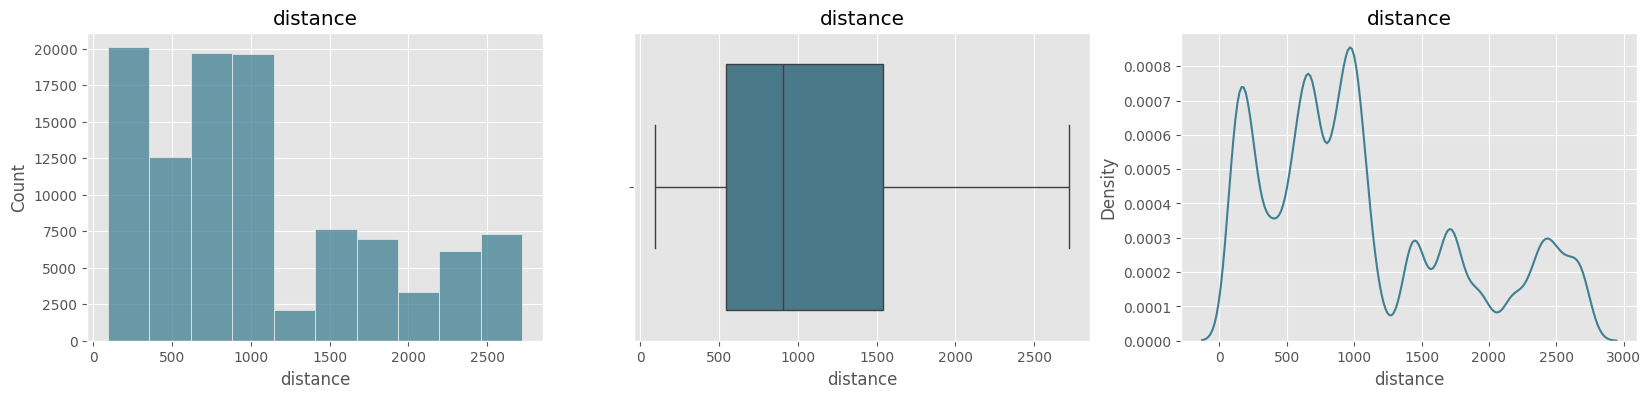

In [59]:
single_variable_multiple_plot(df[["distance"]],type="int64",numeric=True)

**Şirketlerin yaptıkları toplam uçuş mesafeleri.**
- Şirketlerin yaptıkları toplam uçuşları incelediğimizde  en fazla mesafeyi Alaska Airlines Inc. en az mesafeyi Allegiant Air firması yapmıştır. Sıralama ve grafik aşağıda gösterilmiştir.

In [60]:
df.groupby("airline")["distance"].sum().reset_index().sort_values("distance",ascending=False)

,airline,distance
0,Alaska Airlines Inc.,51901234
3,Delta Air Lines Inc.,22395311
11,United Air Lines Inc.,8248029
8,SkyWest Airlines Inc.,7107696
6,Horizon Air,6788743
2,American Airlines Inc.,5814178
9,Southwest Airlines Co.,5747645
5,Hawaiian Airlines Inc.,1884424
7,JetBlue Airways,1386325
10,Spirit Air Lines,662752


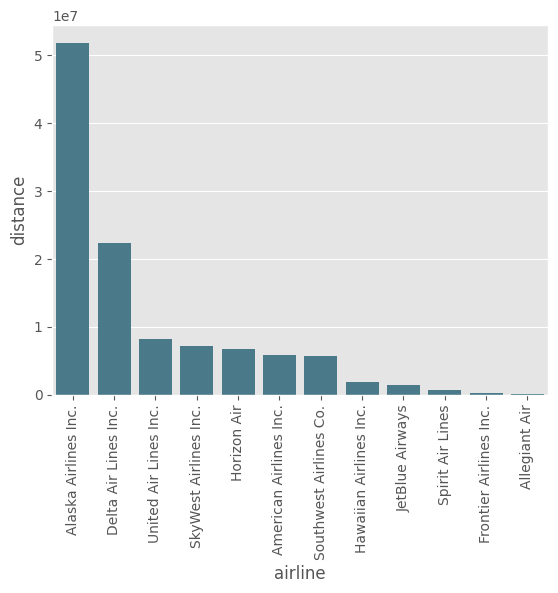

In [61]:
# Hava yoluna göre toplam mesafeler sıralı olarak görselleştirilmiştir.
sorted_airlines = custom_barplot(df,"airline","distance",sum)

**Burada kategorik değişken oluşturma amacıyla her havayolu şirketinin toplam mesafeye oranı tespit edilmiştir.**

In [62]:
total_distance = df["distance"].sum()
distance_ratio = sorted_airlines["distance"]/ total_distance
distance_ratio

0     0.462022
3     0.199362
11    0.073424
8     0.063272
6     0.060433
2     0.051758
9     0.051165
5     0.016775
7     0.012341
10    0.005900
4     0.002672
1     0.000876
Name: distance, dtype: float64

In [63]:
sorted_airlines

,airline,distance
0,Alaska Airlines Inc.,51901234
3,Delta Air Lines Inc.,22395311
11,United Air Lines Inc.,8248029
8,SkyWest Airlines Inc.,7107696
6,Horizon Air,6788743
2,American Airlines Inc.,5814178
9,Southwest Airlines Co.,5747645
5,Hawaiian Airlines Inc.,1884424
7,JetBlue Airways,1386325
10,Spirit Air Lines,662752


**daha önce grafik çizmek amacıyla oluşturulan sorted_airlines dataframeine oranlar eklenmiştir** 

In [64]:
sorted_airlines["distance_ratio_by_total"] = distance_ratio

In [65]:
sorted_airlines

,airline,distance,distance_ratio_by_total
0,Alaska Airlines Inc.,51901234,0.462022
3,Delta Air Lines Inc.,22395311,0.199362
11,United Air Lines Inc.,8248029,0.073424
8,SkyWest Airlines Inc.,7107696,0.063272
6,Horizon Air,6788743,0.060433
2,American Airlines Inc.,5814178,0.051758
9,Southwest Airlines Co.,5747645,0.051165
5,Hawaiian Airlines Inc.,1884424,0.016775
7,JetBlue Airways,1386325,0.012341
10,Spirit Air Lines,662752,0.005900


**12 adet oran kategorisi oluşmuştur**

In [66]:
sorted_airlines["distance_ratio_by_total"].nunique()

12

**merge işlemi öncesi distance kolonu silinmiştir.**

In [67]:
sorted_airlines.drop("distance",inplace=True,axis=1)
sorted_airlines

,airline,distance_ratio_by_total
0,Alaska Airlines Inc.,0.462022
3,Delta Air Lines Inc.,0.199362
11,United Air Lines Inc.,0.073424
8,SkyWest Airlines Inc.,0.063272
6,Horizon Air,0.060433
2,American Airlines Inc.,0.051758
9,Southwest Airlines Co.,0.051165
5,Hawaiian Airlines Inc.,0.016775
7,JetBlue Airways,0.012341
10,Spirit Air Lines,0.005900


**genel veri setine merge ile havayolu şirketinin adı üzerinden birleştirilme yapılmıştır.**

In [68]:
df = df.merge(sorted_airlines, on="airline", how="left")

**Yeni kategorik oran değişkeninin atandığının doğrulaması**
- Yeni değişkenimizin atanması doğrulanmıştır

In [69]:
df["distance_ratio_by_total"].nunique()

12

In [70]:
df.loc[df["airline"]=="Alaska Airlines Inc.", "distance_ratio_by_total"].head()

8     0.462022
10    0.462022
16    0.462022
19    0.462022
22    0.462022
Name: distance_ratio_by_total, dtype: float64

In [71]:
df.loc[df["airline"]=="Allegiant Air", "distance_ratio_by_total"].head()

1208     0.000876
3109     0.000876
4647     0.000876
6822     0.000876
10486    0.000876
Name: distance_ratio_by_total, dtype: float64

**Bu kategori sayısal büyüklük ifade ettiği için  makine öğrenmesi kısmında tekrar dönüştürmemek için sayısal olarak bırakılmıştır.**

# 2.Uçuş mesafeleri, 500 mil altındaki mesafeler, 500-1000 mil arasındaki mesafeler ve 1000 mil ve üzerindeki mesafeler olmak üzere üç ana grupta sınıflandırınız.

In [72]:
df[["distance"]].describe().T

,count,mean,std,min,25%,50%,75%,max
distance,105614.0,1063.636402,746.772089,93.0,543.0,909.0,1542.0,2724.0


- Burada istenilen değerlere göre mesafeler gruplanmış ve veri setine eklenmiştir.

In [73]:
bins = [0, 500, 1000, np.inf]
labels = ["0-500 miles", "500-1000 miles", "1000+ miles"]
df["distance_category"] = pd.cut(df["distance"],bins=bins, labels=labels)

In [74]:
df.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,airline,route,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,date,date_string,dep_delay_check,arr_delay_check,air_time_check,distance_ratio_by_total,distance_category
0,2022,1,1,2022-01-01 01:04:00,2022-01-01 00:43:00,21.0,2022-01-01 09:36:00,2022-01-01 09:30:00,6.0,AA,501,N413AN,SEA,MIA,312.0,2724,0,43,American Airlines Inc.,SEA-MIA,25.0,14.0,62.50,350.0,8.05546,9.270062,0.0,1020.7,10.0,2022-01-01,20220101,21.0,6.0,512.0,0.051758,1000+ miles
1,2022,1,1,2022-01-01 05:13:00,2022-01-01 05:05:00,8.0,2022-01-01 08:52:00,2022-01-01 08:46:00,6.0,UA,850,N24202,SEA,DEN,133.0,1024,5,5,United Air Lines Inc.,SEA-DEN,24.1,17.1,74.27,110.0,6.90468,7.945768,0.0,1023.0,10.0,2022-01-01,20220101,8.0,6.0,219.0,0.073424,1000+ miles
2,2022,1,1,2022-01-01 05:14:00,2022-01-01 05:15:00,-1.0,2022-01-01 08:31:00,2022-01-01 08:45:00,-14.0,WN,558,N7738A,PDX,PHX,121.0,1009,5,15,Southwest Airlines Co.,PDX-PHX,28.0,15.1,57.93,130.0,9.20624,10.594357,0.0,1023.1,10.0,2022-01-01,20220101,-1.0,-14.0,197.0,0.051165,1000+ miles
3,2022,1,1,2022-01-01 05:32:00,2022-01-01 05:35:00,-3.0,2022-01-01 11:09:00,2022-01-01 11:30:00,-21.0,WN,874,N8683D,PDX,MDW,205.0,1751,5,35,Southwest Airlines Co.,PDX-MDW,28.0,15.1,57.93,130.0,9.20624,10.594357,0.0,1023.1,10.0,2022-01-01,20220101,-3.0,-21.0,337.0,0.051165,1000+ miles
4,2022,1,1,2022-01-01 05:37:00,2022-01-01 05:25:00,12.0,2022-01-01 07:29:00,2022-01-01 07:30:00,-1.0,WN,349,N289CT,SEA,OAK,92.0,672,5,25,Southwest Airlines Co.,SEA-OAK,24.1,17.1,74.27,110.0,6.90468,7.945768,0.0,1023.0,10.0,2022-01-01,20220101,12.0,-1.0,112.0,0.051165,500-1000 miles


- Kategorinin dogrulaması

In [75]:
df["distance_category"].value_counts()

distance_category
1000+ miles       42737
500-1000 miles    37836
0-500 miles       25041
Name: count, dtype: int64

# 3.	Havayolu şirketleri arasında en fazla uçuşu gerçekleştiren firmaları belirleyiniz.

- En fazla toplam mesafeye sahip havayolları
- Burda Alaska airlines en fazla mesafeyi yapmıştir. En az mesafeyi Allegiant ait yapmıştır. Sıralama görselde verilmiştir.

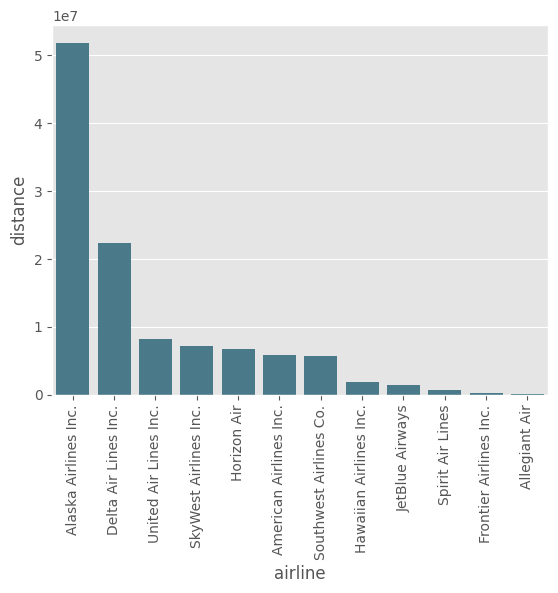

In [76]:
_ = custom_barplot(df,"airline","distance",sum)

- En fazla uçuş yapan havayolları
- Yine Alaska airlines en fazla sayıda uçuş yapmıştır. En az uçuşuda aynı şekilde Allegiant air yapmıştır. Sıralama ve uçuşların % dağılımları görselde verilmiştir.

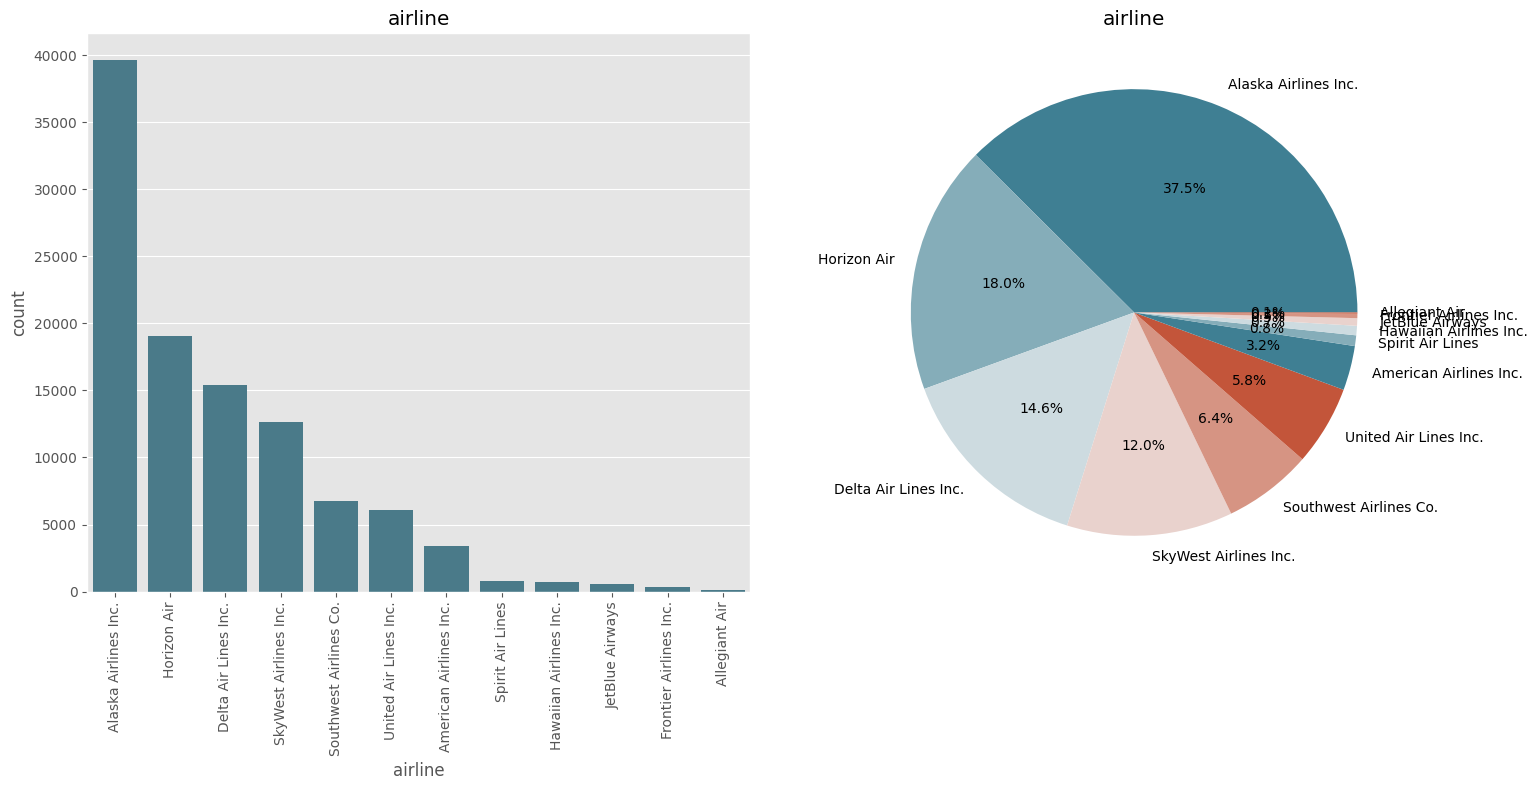

In [77]:
single_variable_multiple_plot(df[["airline"]],type="object",numeric=False)

# 4.	Gecikmeleri varsayarak havayolu şirketlerinin performansları kıyaslayınız.

**Kalkış ve varış gecikme sürelerinin dağılımları**
- Dağılımlar yüksek oranda sağa çarpıktır genelde 0 - 200 aralığındadır.

In [78]:
df[["dep_delay","arr_delay"]].describe().T

,count,mean,std,min,25%,50%,75%,max
dep_delay,105614.0,6.833924,29.388242,-36.0,-5.0,-2.0,6.0,939.0
arr_delay,105614.0,1.176501,31.420228,-65.0,-14.0,-5.0,6.0,907.0


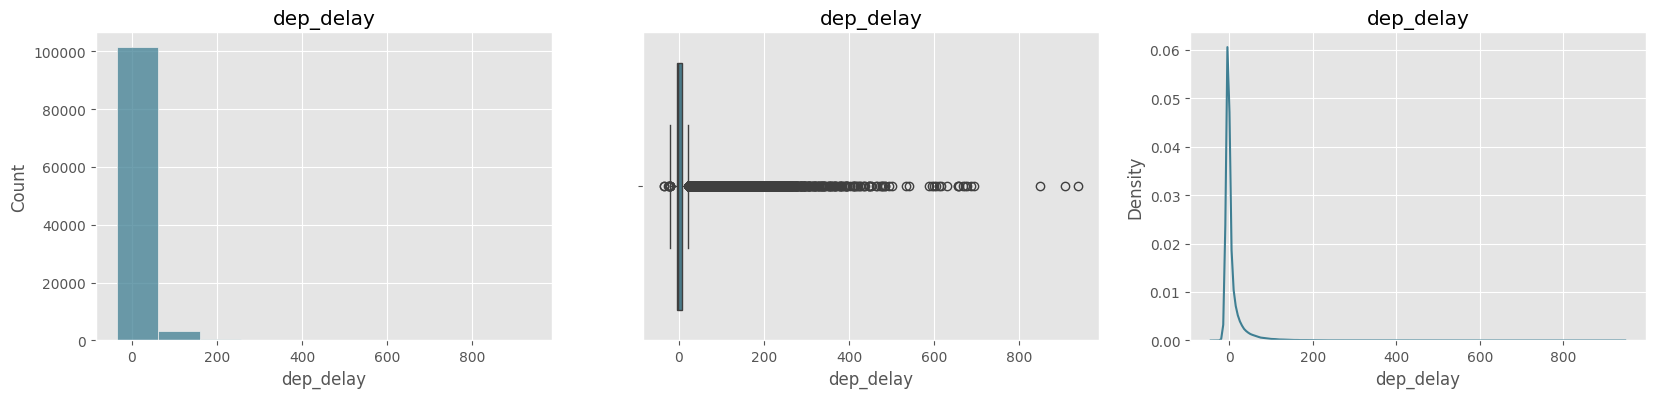

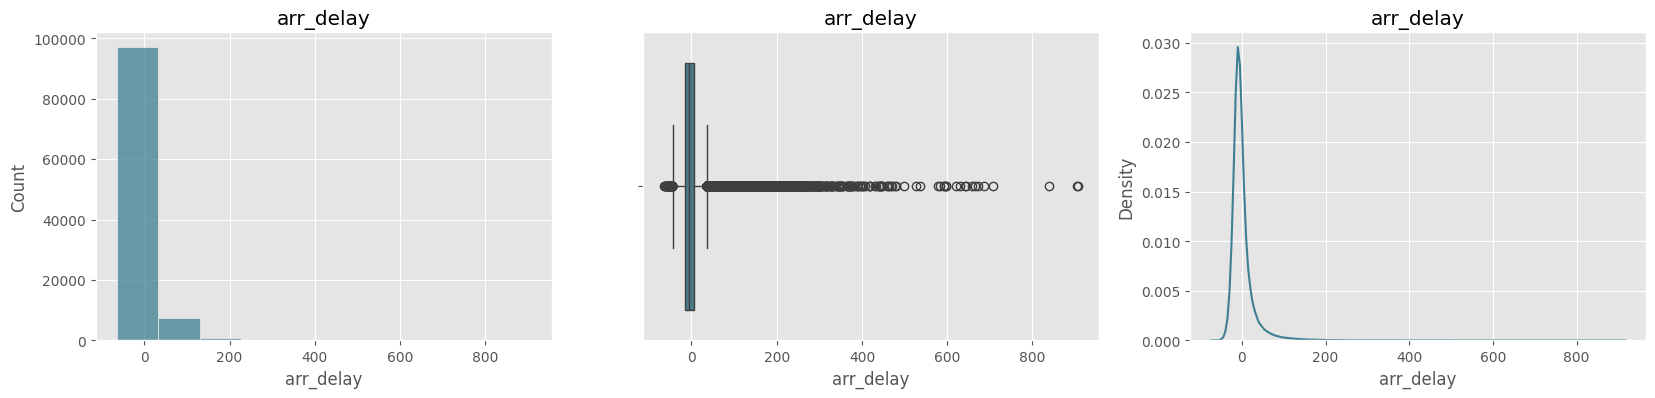

In [79]:
single_variable_multiple_plot(df[["dep_delay","arr_delay"]],numeric=True)


- Aşağıda en fazla varış gecikmesine sahip havayolları (dep_delay) grafiği gösterilmiştir. Burda da toplam değere baktığımızda varış gecikmesi en az olan Allegiant Air olarak gözükmektedir. Ama yine uçuş sayısına orantılı bir değerlendirme yapmak daha faydalı olacaktır. Alaska Airlines en fazla uçuşu yapan firmadır bu nedenle gecikmesi en fazla çıkması doğaldır.

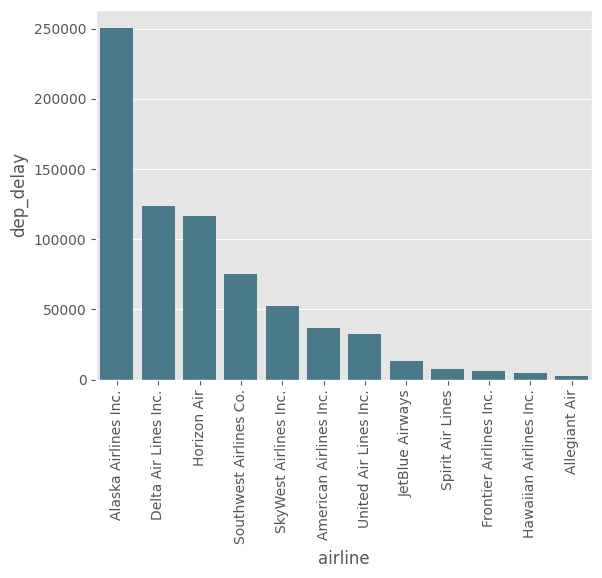

In [80]:
_ = custom_barplot(df, "airline","dep_delay",sum)

- Yine aşağıda en fazla varış gecikmesine sahip havayolları (arr_delay) grafiği gösterilmiştir. Burda da toplam değere baktığımızda varış gecikmesi en az olan United Air Lines olarak gözükmektedir. Ama yine uçuş sayısına orantılı bir değerlendirme yapmak daha faydalı olacaktır. Alaska Airlines en fazla uçuşu yapan firmadır bu nedenle gecikmesi en fazla çıkması doğaldır.

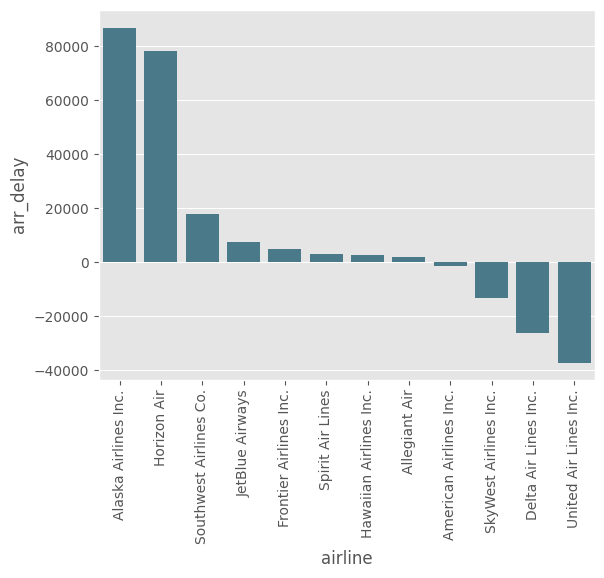

In [81]:
_ = custom_barplot(df, "airline","arr_delay",sum)

**Hava yolları şirketlerinin performans değerlendirmesi bir çok faktöre bağlıdır. Müşteri memnuniyeti anketleri, müşteri yorumları, bütçesi,  uçakların kalitesi vs. Bütün bu bilgilerin derlenip toparlanması için yeterli zaman olmadığından burada günlük kalkış ve varış gecikme değerlerinin toplamını günlük toplam uçuş sayısına bölerek bir performans metriği elde edilmeye çalışıldı. Yapılan bu basit yaklaşımda bu metriğin düşük olması daha iyi performansı ifade etmektedir. Metriği oluşturmak için ilk önce her şirketin günlük uçuş sayısı elde edilmiştir.**

- Havayolu şirketlerinin günlük toplam uçuş sayıları

In [82]:
df.groupby(["airline","date"]).size().reset_index().head()

,airline,date,0
0,Alaska Airlines Inc.,2022-01-01,169
1,Alaska Airlines Inc.,2022-01-02,182
2,Alaska Airlines Inc.,2022-01-03,160
3,Alaska Airlines Inc.,2022-01-04,183
4,Alaska Airlines Inc.,2022-01-05,175


- Her şirketin günlük toplam uçuş sayısının eklenmesi

In [83]:
df["daily_flight_count"] = df.groupby(["airline","date"]).transform("size")

- ekleme işleminin kontrolü

In [84]:
df.groupby(["airline","date"])["daily_flight_count"].mean().reset_index().head()

,airline,date,daily_flight_count
0,Alaska Airlines Inc.,2022-01-01,169.0
1,Alaska Airlines Inc.,2022-01-02,182.0
2,Alaska Airlines Inc.,2022-01-03,160.0
3,Alaska Airlines Inc.,2022-01-04,183.0
4,Alaska Airlines Inc.,2022-01-05,175.0


-  Aşağıda şirketlerin günlük uçuş sayıları (daily_flight_count) grafiği gösterilmiştir. Yine Alaska airlines ilk sırada, Allegiant Air son sıradadır.

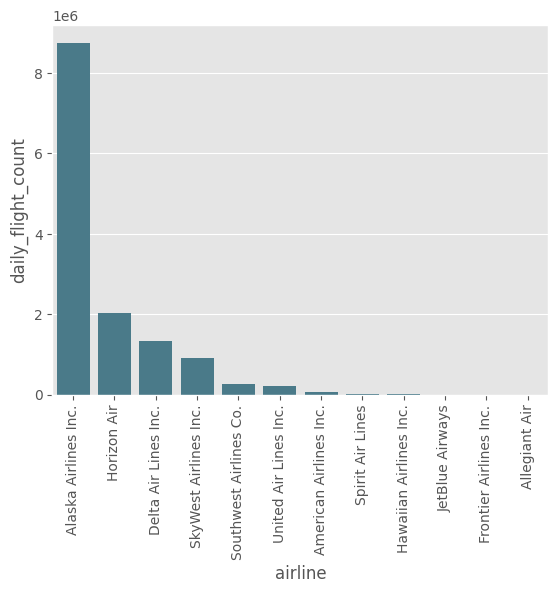

In [85]:
_ = custom_barplot(df, "airline","daily_flight_count",sum)

**Gecikmeleri varsayarak performans metriğinin oluşturulması**
- Yukarıda ayrı ayrı incelenen 3 değişkeni birlikte değerlendirerek airline_daily_performance_kpi oluşturulmuştur.
- Havayolu, ve tarihe göre gruplayarak günlük toplam kalkış geçikmesi,varış gecikmesi, ve ortalamadan elde edilen günlük uçuş sayıları dataframei elde edilmiştir.

In [86]:
df.groupby(["airline","date"]).agg({"dep_delay":sum, "arr_delay":sum, "daily_flight_count":np.mean}).reset_index().head()

,airline,date,dep_delay,arr_delay,daily_flight_count
0,Alaska Airlines Inc.,2022-01-01,3421.0,2683.0,169.0
1,Alaska Airlines Inc.,2022-01-02,5654.0,5046.0,182.0
2,Alaska Airlines Inc.,2022-01-03,3922.0,3576.0,160.0
3,Alaska Airlines Inc.,2022-01-04,3670.0,1567.0,183.0
4,Alaska Airlines Inc.,2022-01-05,4350.0,2503.0,175.0


In [87]:
airline_delay_group = df.groupby(["airline","date"]).agg({"dep_delay":sum, "arr_delay":sum, "daily_flight_count":np.mean}).reset_index()

- airline_daily_performance_kpi hesabı

In [88]:
airline_delay_group["airline_daily_performance_kpi"] = (airline_delay_group["dep_delay"] + airline_delay_group["arr_delay"]) / airline_delay_group["daily_flight_count"]

In [89]:
airline_delay_group.head()

,airline,date,dep_delay,arr_delay,daily_flight_count,airline_daily_performance_kpi
0,Alaska Airlines Inc.,2022-01-01,3421.0,2683.0,169.0,36.118343
1,Alaska Airlines Inc.,2022-01-02,5654.0,5046.0,182.0,58.791209
2,Alaska Airlines Inc.,2022-01-03,3922.0,3576.0,160.0,46.862500
3,Alaska Airlines Inc.,2022-01-04,3670.0,1567.0,183.0,28.617486
4,Alaska Airlines Inc.,2022-01-05,4350.0,2503.0,175.0,39.160000


In [90]:
airline_delay_group.drop(["dep_delay","arr_delay","daily_flight_count"],axis=1,inplace=True)
airline_delay_group.head()

,airline,date,airline_daily_performance_kpi
0,Alaska Airlines Inc.,2022-01-01,36.118343
1,Alaska Airlines Inc.,2022-01-02,58.791209
2,Alaska Airlines Inc.,2022-01-03,46.862500
3,Alaska Airlines Inc.,2022-01-04,28.617486
4,Alaska Airlines Inc.,2022-01-05,39.160000


**oluşturulan metrik veri setine eklenmiştir**

In [91]:
df = df.merge(airline_delay_group, on=["airline","date"], how="left")

**yapılan işlemin doğrulaması**

In [92]:
df.groupby(["airline","date"])["airline_daily_performance_kpi"].mean().reset_index().head()

,airline,date,airline_daily_performance_kpi
0,Alaska Airlines Inc.,2022-01-01,36.118343
1,Alaska Airlines Inc.,2022-01-02,58.791209
2,Alaska Airlines Inc.,2022-01-03,46.862500
3,Alaska Airlines Inc.,2022-01-04,28.617486
4,Alaska Airlines Inc.,2022-01-05,39.160000


**Elde edilen grafiğe göre gecikmelerin az olması açısından performansı en iyiler United Airlines inc, Skywest Airlines, Delta Airlines, Alaska Airlines şeklinde küçükten büyüğe girmektedir. En kötü performans Allegiant Air'a aitttir.**

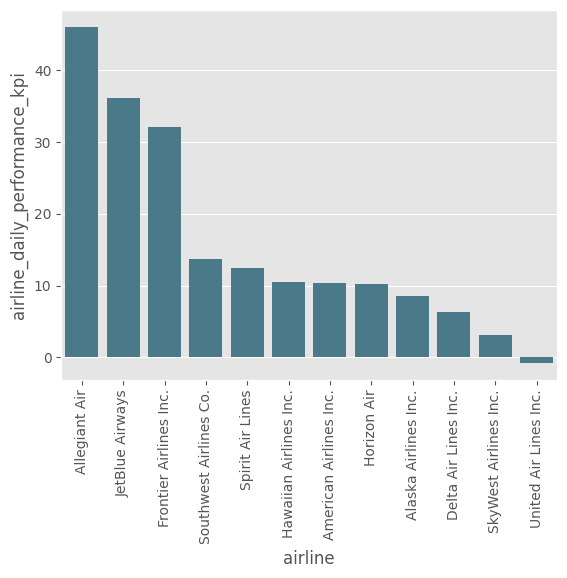

In [93]:
_ = custom_barplot(df,"airline","airline_daily_performance_kpi",np.mean)

# 5.	Havayolu performansının yılın farklı aylarına göre değişip değişmediğini ve en iyi 5 havayolu performansı ile en kötü 5 performansı gösteriniz.

**Oluşturmuş performans metriğinin aylara göre değişimi incelenmiştir**

In [94]:
df["month_check"] = df["date"].dt.month

**veri setindeki ay ile kendi oluşturduğumuz date verisindeki ay değerinin karşılaştırmasını yapıldı. Hata bulunmamaktadır.**

In [95]:
month_check = df['month'] == df['month_check']
diff_month = len(df) - month_check.sum()
print("Değerleri farklı olan satır sayısı:", diff_month)

Değerleri farklı olan satır sayısı: 0


**Aylık havayolu performanslarını tespit etmek için havayolu ve ay ile gruplama yapılıp oluşturulan airline_daily_performance_kpi'ların ortalama değerlerine bakılmıştır.**
- Tekrar bahsetmek gerekirse airline_daily_performance_kpi değeri günlük kalkış ve iniş gecikmelerinin toplamının yine günlük toplam uçuş sayısına bölünmesi ile elde edilmiştir. Bu nedenle performans göstergesi bu değerin düşük olmasıdır.
- Buna göre genel değerlendirme olarak uçuşların çok yoğun olmadığı 1. 2. 3. ocak, şubat, mart aylarında performanslar daha iyi, uçuşların yoğunlaşmaya başladığı nisan mayıs haziran aylarında giderek genel performans düşmektedir.

In [96]:
monthly_performance = df.groupby(["airline","month"])["airline_daily_performance_kpi"].mean().reset_index()
monthly_performance.head()

,airline,month,airline_daily_performance_kpi
0,Alaska Airlines Inc.,1,11.779439
1,Alaska Airlines Inc.,2,3.842943
2,Alaska Airlines Inc.,3,5.379576
3,Alaska Airlines Inc.,4,15.596686
4,Alaska Airlines Inc.,5,6.852247


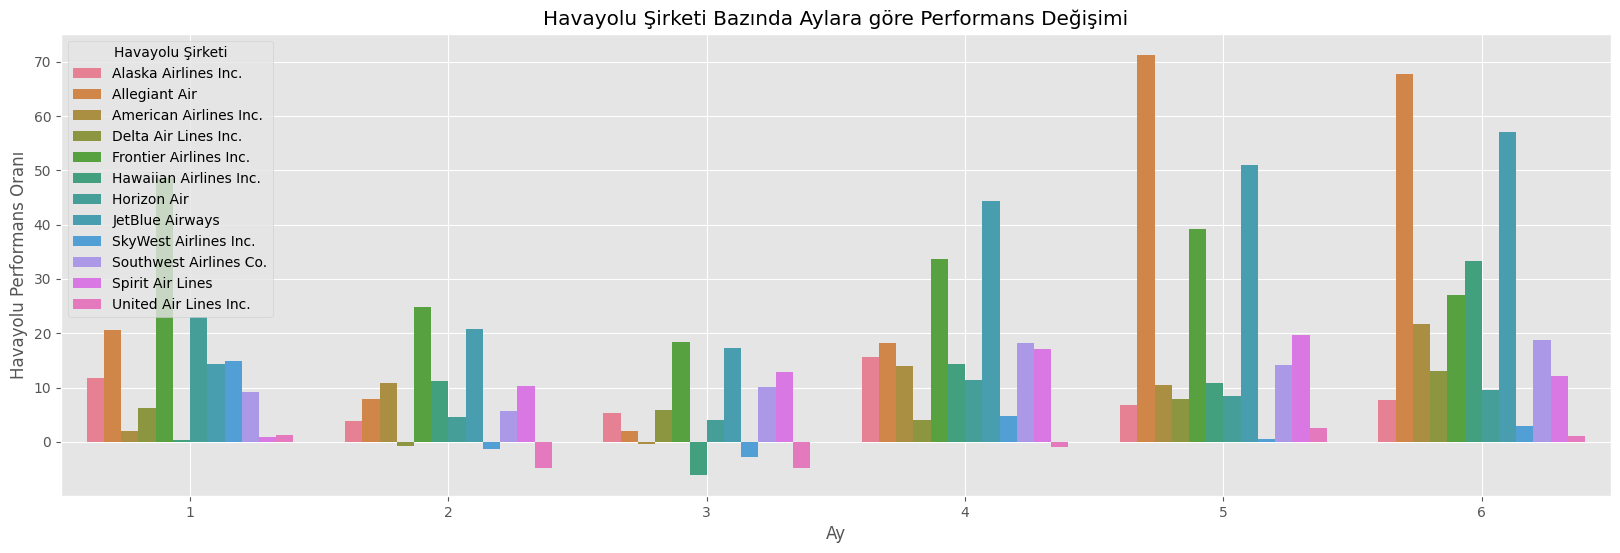

In [97]:
plt.figure(figsize=(20, 6))
sns.barplot(data=monthly_performance, x="month", y="airline_daily_performance_kpi", hue="airline")
plt.title("Havayolu Şirketi Bazında Aylara göre Performans Değişimi")
plt.xlabel("Ay")
plt.ylabel("Havayolu Performans Oranı")
plt.legend(title="Havayolu Şirketi",loc="upper left")
plt.grid(True)
plt.show()

**Aylık gecikmelere göre performansı en iyi 5 havayolu**
- Burda oluşturulan monthly_performance dataframemi tekrar aya göre gruplayarak nsmallest ile en düşük kpi olan 5 şirket filtrelenmiştir.
- Her ay için performansı en iyi şirketler aşağıdaki tabloda ve görselde listelenmiştir.
- Kısaca değerlendirecek olunursa, uçuşların çok yoğun olmadığı ilk 3 ayda performansları en iyiler sırasıyla, Hawaiian Airlines Inc., United Air Lines Inc ve tekrar Hawaiian Airlines Inc. en performanslıdır. Aylara göre şirketlerin performansı değişmektedir.
- yoğunluğun başladığı 4., 5 ve 6. aylarda en iyiler sırasıyla United Air Lines Inc., SkyWest Airlines Inc. ve United Air Lines Inc. yer almaktadır.
- Buna göre United Air Lines Inc. yoğun olmayan ve yoğun dönemlerde de başarılı bir şirkettir diyebiliriz.

In [98]:
best_performers = monthly_performance.groupby("month").apply(lambda x: x.nsmallest(5,"airline_daily_performance_kpi")).reset_index(drop=True)
best_performers

,airline,month,airline_daily_performance_kpi
0,Hawaiian Airlines Inc.,1,0.418605
1,Spirit Air Lines,1,0.815789
2,United Air Lines Inc.,1,1.340554
3,American Airlines Inc.,1,1.969052
4,Delta Air Lines Inc.,1,6.161633
5,United Air Lines Inc.,2,-4.868145
6,SkyWest Airlines Inc.,2,-1.369666
7,Delta Air Lines Inc.,2,-0.729001
8,Alaska Airlines Inc.,2,3.842943
9,Horizon Air,2,4.642396


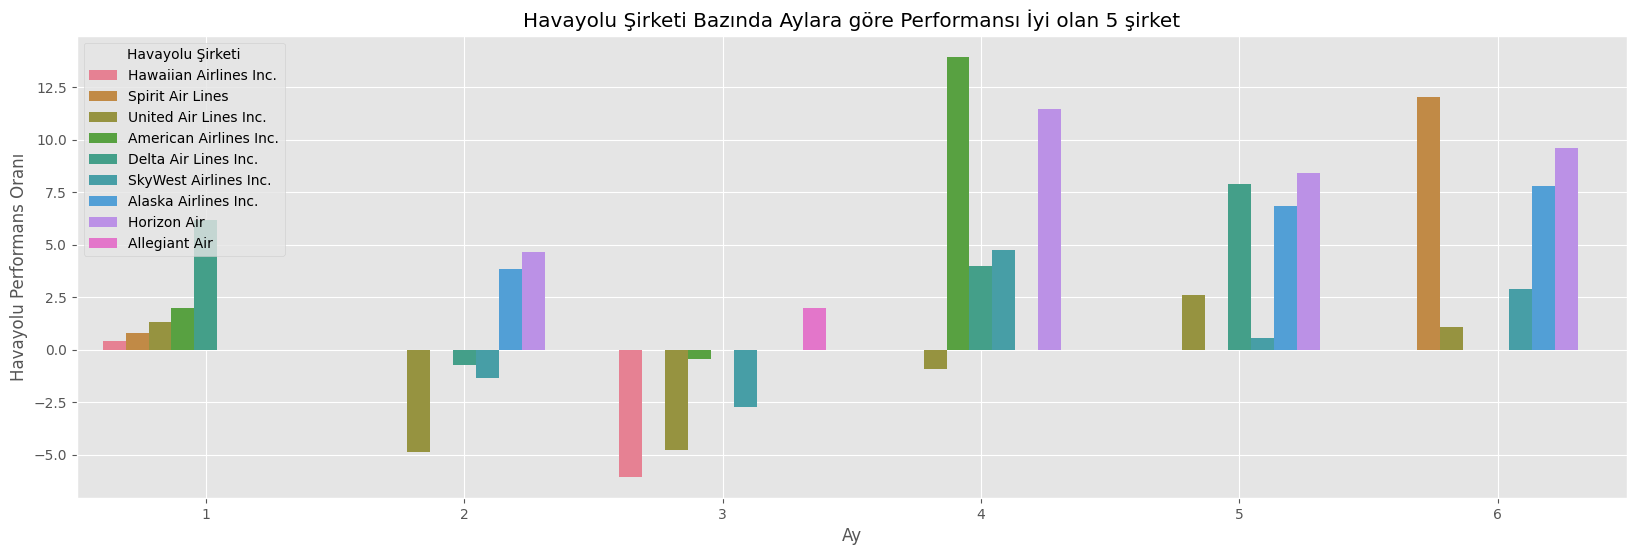

In [99]:
plt.figure(figsize=(20, 6))
sns.barplot(data=best_performers, x="month", y="airline_daily_performance_kpi", hue="airline")
plt.title("Havayolu Şirketi Bazında Aylara göre Performansı İyi olan 5 şirket")
plt.xlabel("Ay")
plt.ylabel("Havayolu Performans Oranı")
plt.legend(title="Havayolu Şirketi",loc="upper left")
plt.grid(True)
plt.show()


**Aylık gecikmelere göre performansı en kötü 5 havayolu**
- Burda da yine aynı mantıkla oluşturulan monthly_performance dataframemi tekrar aya göre gruplayarak nlargest ile en yüksek kpi olan 5 şirket filtrelenmiştir. Kpi yüksekse performans kötüdür.
- Her ay için performansı en kötü şirketler aşağıdaki tabloda ve görselde listelenmiştir.
- Kısaca değerlendirecek olunursa, uçuşların çok yoğun olmadığı ilk 3 ayda performansı en kötü şirket Frontier Airlines Inc.'dır.
- Yoğunluğun başladığı 4., 5. ayda performansı ek kötü şirket JetBlue Airways 6. ayda Allegiant Air'dir.

In [100]:
worst_performance = monthly_performance.groupby("month").apply(lambda x: x.nlargest(5,"airline_daily_performance_kpi")).reset_index(drop=True)
worst_performance

,airline,month,airline_daily_performance_kpi
0,Frontier Airlines Inc.,1,48.490909
1,Horizon Air,1,23.001605
2,Allegiant Air,1,20.625000
3,SkyWest Airlines Inc.,1,14.830437
4,JetBlue Airways,1,14.308642
5,Frontier Airlines Inc.,2,24.760870
6,JetBlue Airways,2,20.769231
7,Hawaiian Airlines Inc.,2,11.234234
8,American Airlines Inc.,2,10.908019
9,Spirit Air Lines,2,10.328467


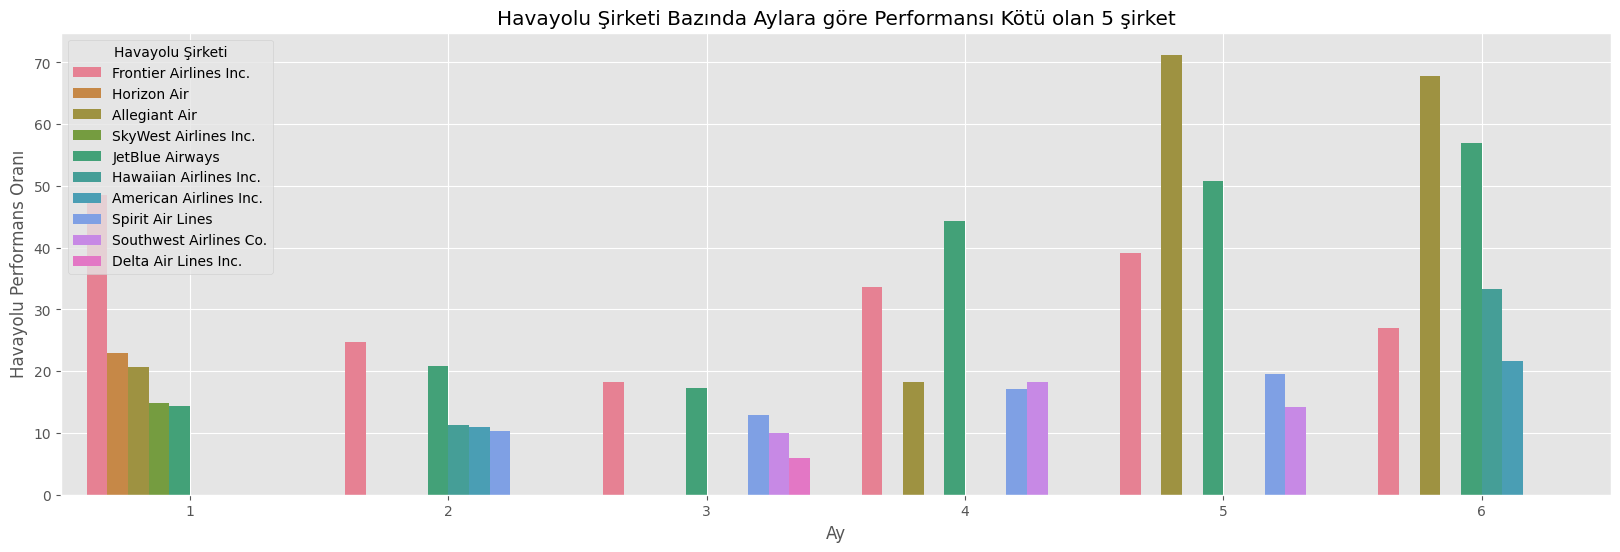

In [101]:

plt.figure(figsize=(20, 6))
sns.barplot(data=worst_performance, x="month", y="airline_daily_performance_kpi", hue="airline")
plt.title("Havayolu Şirketi Bazında Aylara göre Performansı Kötü olan 5 şirket")
plt.xlabel("Ay")
plt.ylabel("Havayolu Performans Oranı")
plt.legend(title="Havayolu Şirketi",loc="upper left")
plt.grid(True)
plt.show()

# 6.	Uçuş iptallerinin yüzde kaç olduğunu belirleyip havayoluna göre değişkenliğini gösteriniz?

**Eksik verileri temizleme kısmında cevabı verildi**

# 7.	Rotar Süresinin daha yüksek olduğu günün belirli bir saati ve/veya yılın saati var mı?

**Veri setindeki saatleri incelemesi yapıldığında hour değişkeninin sched_dep_time'dan oluşturulduğu tespit edilmiştir. Bu nedenle hour değişkeni kullanılarak analiz yapılmıştır. Ayrıca geçikmelerin en çok hangi saatte yaşandığını tespit etmek için mantıklı olan planlanan zamandaki saati baz almak olabilir.**

**dep_time hour kontrolü**
- Burda ana veri setinde bulunan hour değişkenine göre meydana gelen farklılığın nedeni hour değişkeninin planlanan uçuş zamanına göre veri setine eklenmesidir(sched_dep_time).

In [102]:
df["hour_check_dep"] = df["dep_time"].dt.hour

In [103]:
hour_check_dep = df['hour'] == df['hour_check_dep']
diff_hour_dep = len(df) - hour_check_dep.sum()
print("Değerleri farklı olan satır sayısı:", diff_hour_dep)

Değerleri farklı olan satır sayısı: 23442


**sched_dep_time hour kontrolü**
- Burda veri setindeki hour değişkeninin sched_dep_time verisinden oluşturulduğunu görüyoruz. Verileri incelediğimizde 2, 3 ve 4. saatler bulunmamaktadır.
- Kalkış yeri olarak veri setinde 2 havaalanı bulunmaktadır (SEA, PDX) 2, 3 ve 4. saatlerde hiç gecikme bulunmaması bu hava alanlarında saat 2,3 ve 4 de uçuş planlaması yapılmadığını gösterebilir.

In [104]:
df[["origin"]].value_counts()

origin
SEA       78169
PDX       27445
Name: count, dtype: int64

In [105]:
df["hour_check_sched"] = df["sched_dep_time"].dt.hour

In [106]:
hour_check_sched = df['hour'] == df['hour_check_sched']
diff_hour_sched = len(df) - hour_check_sched.sum()
print("Değerleri farklı olan satır sayısı:", diff_hour_sched)

Değerleri farklı olan satır sayısı: 0


In [107]:
# saatlere göre toplam rötar sayıları
df.groupby("hour")["dep_delay"].sum().reset_index().head(6)

,hour,dep_delay
0,0,9998.0
1,1,73.0
2,5,6897.0
3,6,13403.0
4,7,34329.0
5,8,37002.0


**Saatlik uçuş sayıları**
- Saatlik gruplayıp uçuş sayılarına baktığımızda gerçektende 2, 3 ve 4 saatlerinde uçuş yapılmadığını görüyoruz.

In [108]:
hourly_flight_count = df.groupby("hour").size().reset_index()
hourly_flight_count= hourly_flight_count.rename(columns={0:"hourly_flight_count"})
hourly_flight_count.head()

,hour,hourly_flight_count
0,0,155
1,1,18
2,5,2854
3,6,5749
4,7,8827


**Saatlik uçuş sayıları grafiği**
- Bu grafiği incelediğimizde en çok uçuşların saat 07:00 ve 11:00 de yapıldığı, en az uçuşunda saat 01:00, 00:00 ve 05:00 saatlerinde yapıldığını görüyoruz.

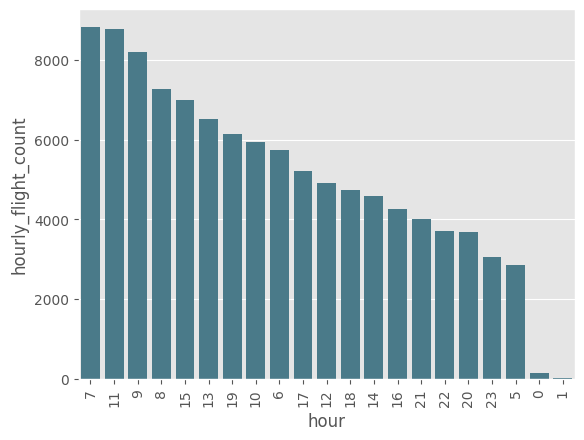

In [109]:
_ = custom_barplot(hourly_flight_count,"hour","hourly_flight_count",sum)

**Saatlik rötarlar**

In [110]:
total_hourly_delays = df.groupby("hour")["dep_delay"].sum().reset_index()
total_hourly_delays

,hour,dep_delay
0,0,9998.0
1,1,73.0
2,5,6897.0
3,6,13403.0
4,7,34329.0
5,8,37002.0
6,9,46508.0
7,10,40886.0
8,11,71373.0
9,12,37704.0


**Saatlik rötar grafiği**
- 7.sorunun cevabı olarak bu grafiği incelediğimizde yoğun uçuş saati olan 11:00 da en çok rötar olduğu görülmektedir. Ama en yoğun uçuş sayısının olduğu saat 07:00 da rötar miktarı daha azdır. Buda hava alanlarının çeşitli faktörlerden dolayı 07:00 saatinde geçikme yaşanmaması için daha çok önlem aldığını gösterebilir. Bu saate neden önem verildiği konusunda daha detay analiz yapılabilir. Gecikmelerin en az olduğu saatler yine uçuş süresininde en az olduğu 01:00, 05:00 ve 00:00  saatidir. Burda 00:00 saati için özel bir durum vardır. Uçuş sayısı çok az olmasına rağmen gecikme çok fazladır. Bu durum günün saatinin tam değiştiği zamana denk gelmesinden dolayı olabilir. 

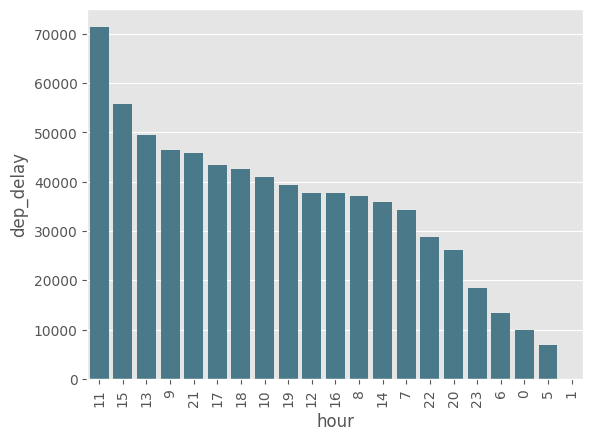

In [111]:
_ = custom_barplot(total_hourly_delays,"hour","dep_delay",sum)

# 8.	En yüksek ROTAR(gecikme) süresine sahip güzergahlar hangileri?

**Veri setrinde 149 adet güzergah vardır**

In [112]:
df[["route"]].value_counts().shape

(149,)

**En yüksek rötar süresine sahip ilk 5 güzergah SEA-ANC, SEA-PDX, SEA-LAS, SEA-DEN ve SEA-LAX 'dir.**

In [113]:
df.groupby("route")["dep_delay"].sum().reset_index().sort_values("dep_delay",ascending=False).head()

,route,dep_delay
58,SEA-ANC,28868.0
121,SEA-PDX,27451.0
102,SEA-LAS,24760.0
76,SEA-DEN,22537.0
103,SEA-LAX,21488.0


**En az rötar süresi olan 5 güzergahda PDX-SNA, PDX-TPA, PDX-BZN, PDX-SBP ve PDX-LIH'dır.**

In [114]:
df.groupby("route")["dep_delay"].sum().reset_index().sort_values("dep_delay",ascending=False).tail()

,route,dep_delay
51,PDX-SNA,35.0
54,PDX-TPA,18.0
7,PDX-BZN,-10.0
45,PDX-SBP,-80.0
28,PDX-LIH,-310.0


In [115]:
routes = df.groupby("route")["dep_delay"].sum().reset_index().head(10)

**En yüksek rötar süresine sahip ilk 10 güzergahın sıralı görseleştirilmesi**

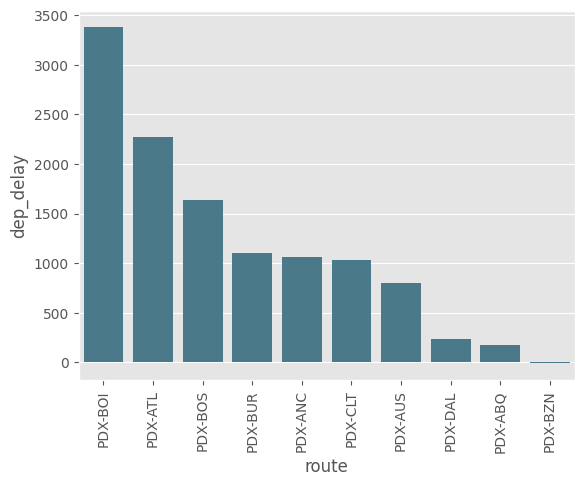

In [116]:
_ = custom_barplot(routes,"route","dep_delay",sum)

# İlave İşlemler

**Uçak sayısı eklenmesi**

- Kuyruk numarası değişkeni saydırılığ firma başı uçak sayısı hesaplanmıştır.
- En fazla uçağa sahip havayou firması Southwest Airlines Co. en az uçağa sahip havayolu firması Allegiant Air'dir. Sıralamalı liste ver görsel aşağıda sunulmuştur. 
- Uçak sayılarınıda veri setine kategorik değişken olarak eklenmiştir.

In [117]:
df.groupby("airline")["tailnum"].nunique().reset_index().sort_values("tailnum",ascending=False)

,airline,tailnum
9,Southwest Airlines Co.,728
2,American Airlines Inc.,612
3,Delta Air Lines Inc.,610
11,United Air Lines Inc.,525
8,SkyWest Airlines Inc.,272
0,Alaska Airlines Inc.,228
7,JetBlue Airways,157
10,Spirit Air Lines,120
4,Frontier Airlines Inc.,108
6,Horizon Air,61


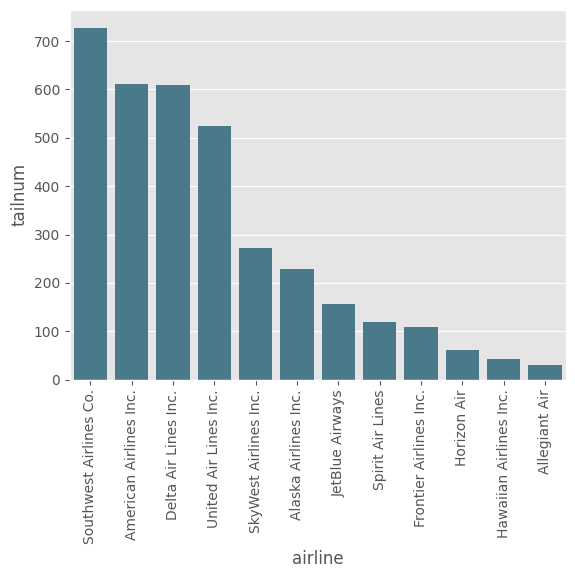

In [118]:
airline_total_aircraft_count = df.groupby("airline")["tailnum"].nunique().reset_index()
_ = custom_barplot(airline_total_aircraft_count,"airline","tailnum",sum)

- Uçak sayısının veri setine eklenmesi.

In [119]:
airline_total_aircraft_count = df.groupby("airline")["tailnum"].nunique()
df["aircraft_count_by_airline"] = df["airline"].map(airline_total_aircraft_count)

In [120]:
df.groupby("airline")["aircraft_count_by_airline"].mean().reset_index()

,airline,aircraft_count_by_airline
0,Alaska Airlines Inc.,228.0
1,Allegiant Air,30.0
2,American Airlines Inc.,612.0
3,Delta Air Lines Inc.,610.0
4,Frontier Airlines Inc.,108.0
5,Hawaiian Airlines Inc.,42.0
6,Horizon Air,61.0
7,JetBlue Airways,157.0
8,SkyWest Airlines Inc.,272.0
9,Southwest Airlines Co.,728.0


# Hangi rotaların 1. seviye gecikme sınıfına girme olasılığı en yüksek?


<span style="color: green"> Gecikme sürelerini cut veya qcut fonksiyonları ile 5 parçaya bölerek kategorik bir değişken oluşturunuz.</span>

<span style="color: green">Örneğin: En az gecikme 1. Seviye, en çok gecikme 5. seviye olmak üzere</span>

- Burda gecikme süresi olarak dep_delay baz alınmıştır.

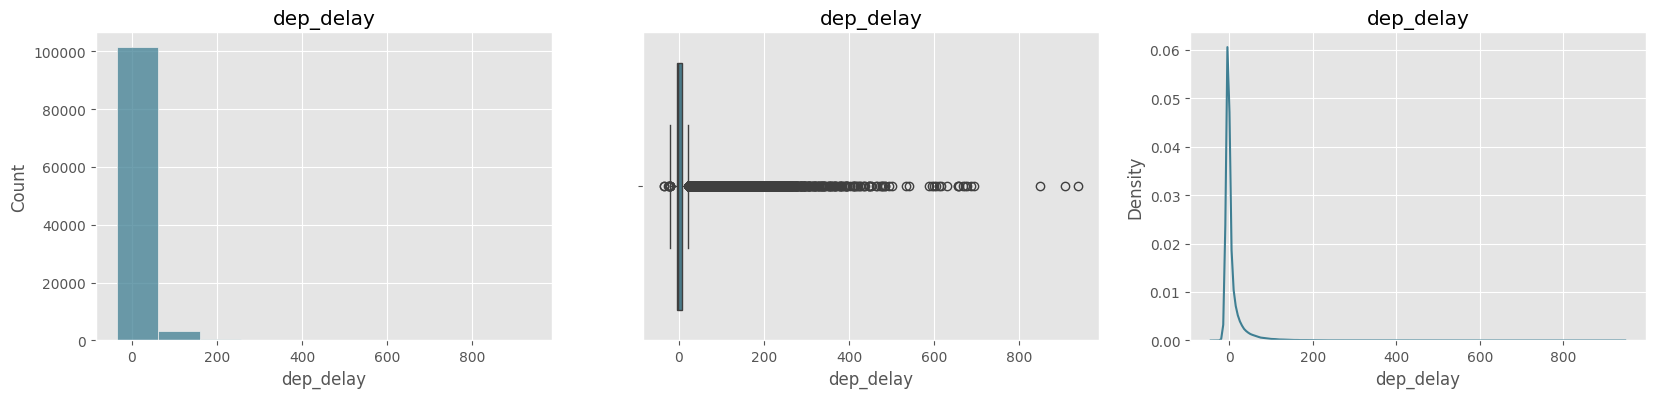

In [121]:
single_variable_multiple_plot(df[["dep_delay"]],numeric=True)

In [122]:
df[["dep_delay"]].describe().T

,count,mean,std,min,25%,50%,75%,max
dep_delay,105614.0,6.833924,29.388242,-36.0,-5.0,-2.0,6.0,939.0


In [123]:
df[["route"]].nunique()

route    149
dtype: int64

**Özet istatistikler baz alılarak dep_delay 5 parçaya bölünmüştür. En az gecikme 1. seviye en çok gecikme 5. seviye olarak adlandırılmıştır.**

In [124]:
bins = [-np.inf, -10.0, -5.0, 0.0, 5.0, np.inf]
labels= ["1.Seviye","2.Seviye","3.Seviye","4.Seviye","5.Seviye"]
df["dep_delay_category"] = pd.cut(df["dep_delay"],bins=bins, labels=labels)

- grupların atanması kontrol edilmiştir. İstenilen şekilde yapılmıştır.

In [125]:
df[["dep_delay_category"]].value_counts().reset_index()

,dep_delay_category,count
0,3.Seviye,37620
1,5.Seviye,27336
2,2.Seviye,26049
3,4.Seviye,11131
4,1.Seviye,3478


In [126]:
df.groupby("dep_delay_category")["dep_delay"].mean().reset_index()

,dep_delay_category,dep_delay
0,1.Seviye,-11.522714
1,2.Seviye,-6.448731
2,3.Seviye,-2.201542
3,4.Seviye,2.728506
4,5.Seviye,35.933128


**Hangi rotanın hangi kategoride gecikme süresine sahip olduğunun belirlenmesi**
- Bunun için hangi seviyede kaç rota var sorgusu yapılıp bu değer toplam rota sayısına bölünüp olasılıklar hesaplanmıştır.

In [127]:
route_dep_delay_probabilities =df.groupby(["route", "dep_delay_category"]).size() / df.groupby("route").size()
route_dep_delay_probabilities.head().reset_index()

,route,dep_delay_category,0
0,PDX-ABQ,1.Seviye,0.086093
1,PDX-ABQ,2.Seviye,0.331126
2,PDX-ABQ,3.Seviye,0.350993
3,PDX-ABQ,4.Seviye,0.066225
4,PDX-ABQ,5.Seviye,0.165563


- unstack ile seviyeler değişkenlere dönüştürülmüştür.

In [128]:
route_dep_delay_probabilities.unstack().head().reset_index()

dep_delay_category,route,1.Seviye,2.Seviye,3.Seviye,4.Seviye,5.Seviye
0,PDX-ABQ,0.086093,0.331126,0.350993,0.066225,0.165563
1,PDX-ANC,0.091324,0.255708,0.210046,0.123288,0.319635
2,PDX-ATL,0.010676,0.120996,0.517794,0.172598,0.177936
3,PDX-AUS,0.068493,0.438356,0.178082,0.123288,0.191781
4,PDX-BOI,0.021994,0.290323,0.420821,0.082111,0.184751


**1. Seviye gecikme sınıfına girme olasılığı en yüksek 10 rota belirlenmiştir.**
- ilk 3 sırada PDX-OGG, PDX-SNA ve PDX-TUS rotaları yer almaktadır.

In [129]:
level_1_probabilities= route_dep_delay_probabilities.unstack()["1.Seviye"]
level_1_probabilities.nlargest(10).reset_index()

,route,1.Seviye
0,PDX-OGG,0.185294
1,PDX-SNA,0.180583
2,PDX-TUS,0.164179
3,PDX-DCA,0.135294
4,PDX-PAE,0.125000
5,SEA-PIT,0.120482
6,PDX-SAN,0.111898
7,PDX-SBP,0.111111
8,PDX-FAT,0.109375
9,PDX-LIH,0.102740


In [130]:
top_10_level1_routes = level_1_probabilities.nlargest(10).reset_index()

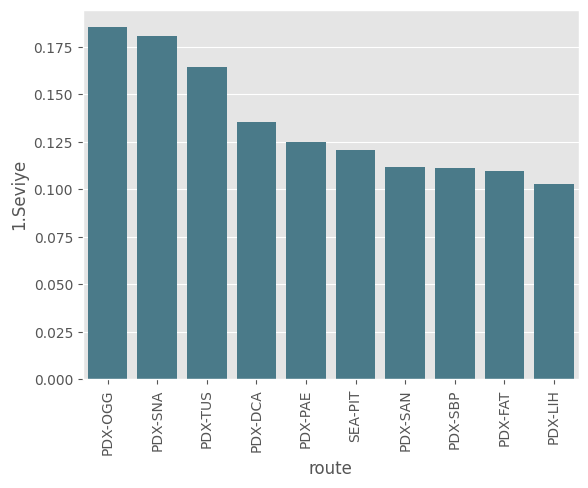

In [131]:
_ = custom_barplot(top_10_level1_routes,"route","1.Seviye",sum)

# 9.	Makine öğrenmesi modeli kurup uçuşların gecikme sürelerini tahmin ediniz.
# 10.	Modeli Değerlendiriniz.
**9 ve 10. sorular birlikte değerlendirilmiştir.**

# Korelasyon Analizi
- Hedef değişkenimiz dep_delay dir. Bu değişken ile diğer sayısal değişkenlerin arasında bir korelasyon olup olmadığı analiz edilmiştir. Analizden önce kontrol yada hesaplama amacıyla oluşturulmuş sütünlar kaldırılmıştır.
- Burada pairplot çizimide yapılabilir ama çok yer kapladığından eklenmemiştir.




In [132]:

columns_to_be_remove = ["date_string","dep_delay_check","arr_delay_check","air_time_check","month_check","hour_check_dep","hour_check_sched"]
df.drop(columns_to_be_remove, axis=1, inplace=True)
df.columns

Index(['year', 'month', 'day', 'dep_time', 'sched_dep_time', 'dep_delay',
       'arr_time', 'sched_arr_time', 'arr_delay', 'carrier', 'flight',
       'tailnum', 'origin', 'dest', 'air_time', 'distance', 'hour', 'minute',
       'airline', 'route', 'temp', 'dewp', 'humid', 'wind_dir', 'wind_speed',
       'wind_gust', 'precip', 'pressure', 'visib', 'date',
       'distance_ratio_by_total', 'distance_category', 'daily_flight_count',
       'airline_daily_performance_kpi', 'aircraft_count_by_airline',
       'dep_delay_category'],
      dtype='object')



**Heatmap incelemesi ve birbiri arasında korelasyonlu değişkenlerin tespiti**

- Burada görselin daha anlaşılır olması için np.triu ile ones_like birlikte kullanılarak bool değerler oluşurup üst üçgenin gösterilmemesini sağlanmıştır.
Aşağıda heatmapi incelediğimizde korelasyonlar renkler ile açıkça görülmektedir.

Değişkenler arasında %70 den fazla korelasyonu olanlar multicollinearity problemi oluşmaması için korelasyonlu olanları biri kullanılmayacaktır.
Yüksek korelasyonlu değişkenler aynı bilgiyi ifade ettiklerinden aralarındaki küçük farklar makine öğrenimi modelini yanıltabilir.

Bu değişkenler:
- arr_delay - dep delay: dep delay zaten target değişken olduğundan arr_delay tek başına kullanılabilir.
- distance - air_time: 0.99 luk çok yüksek korelasyon vardır. air_time modelde kullanılmayacaktır.
- flight - distance_ratio_by_total: 0.70 lik negatif yönde yüksek korelasyon vardır. flight değişkeni zaten kardinalitesi yüksek bir sayısal değişken olduğu için kullanılmayacaktır.
- temp - dewp: dewp çiğ noktasını temp sıcaklığı ifade eder. 0.75 korelasyon olduğundan dewp kullanılmayacaktır.
- wind_speed - wind_gust: aralarında 1 yani tam pozitif korelasyon vardır. Aynı şeyi ifade ettiklerinden wind_gust kullanılmayacaktır.
- distance_ratio_by_total - daily_flight_count: yine 0.92 lik çok yüksek korelasyon olduğundan daily_flight_count kullanılmayacaktır.

Diğer negatif ve pozitif korelasyonlar tablodan görülmektedir.

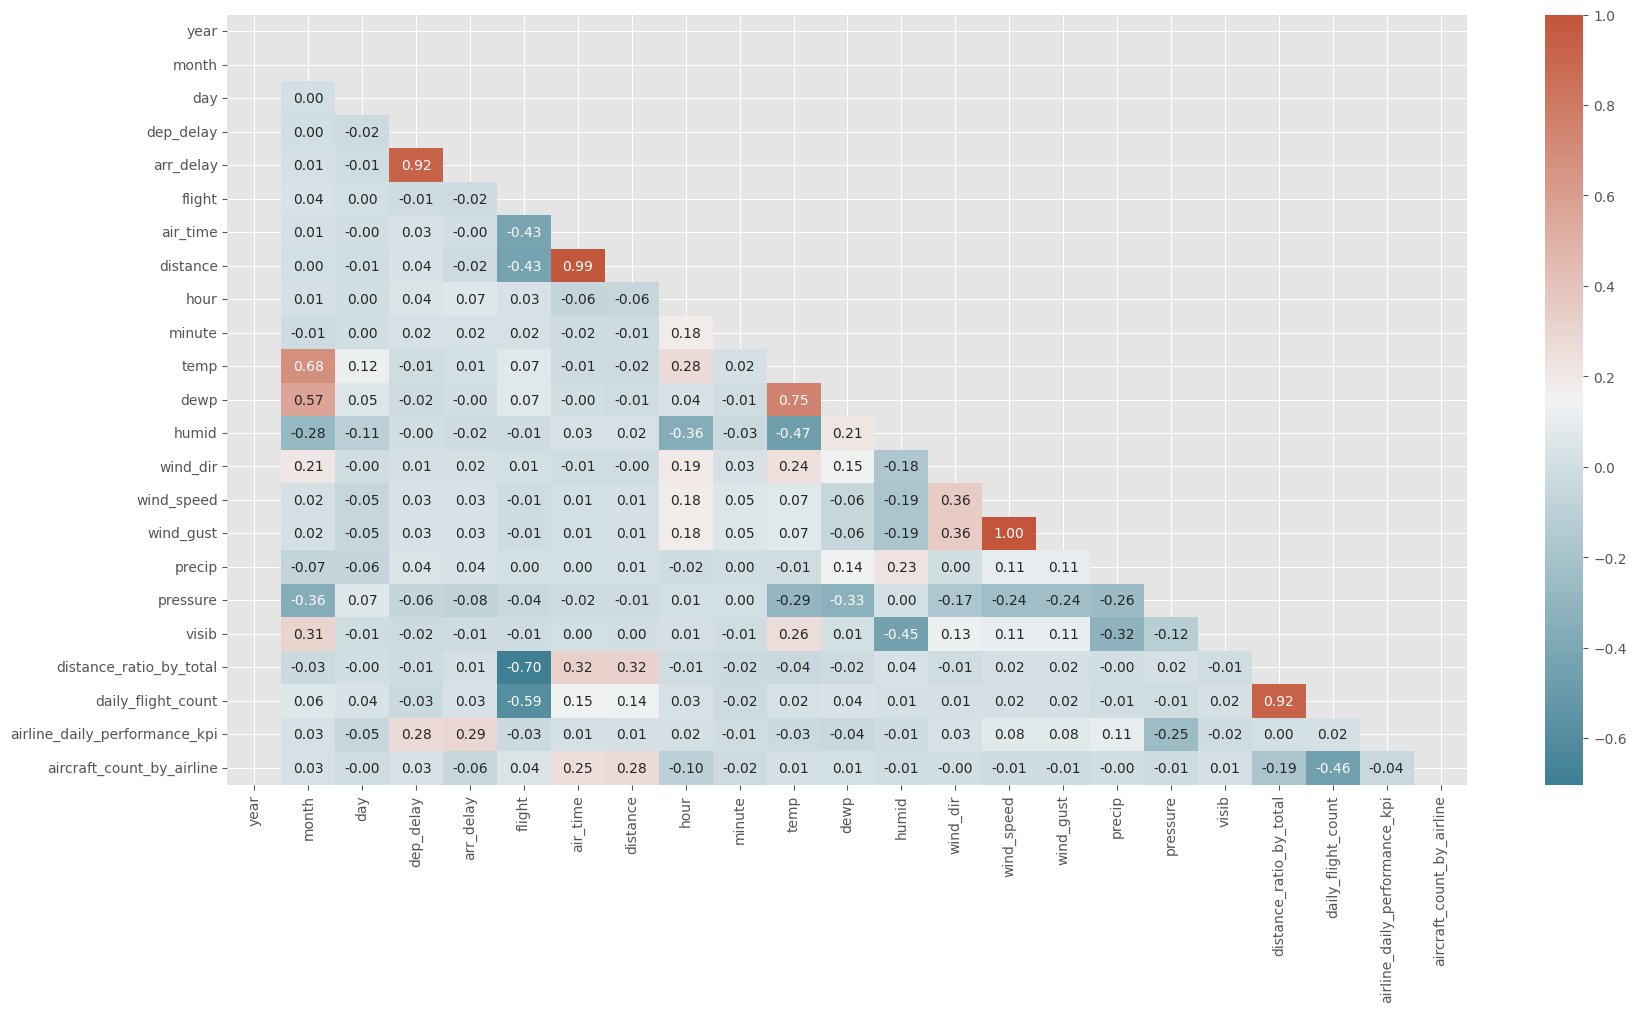

In [133]:
plt.figure(figsize=(20, 10))
num_variables = df.select_dtypes(include=["float64","int64"])
corr_df = num_variables.corr()
mask = np.triu(np.ones_like(corr_df, dtype=bool))
tri_df = corr_df.mask(mask)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(tri_df,annot=True,fmt=".2f",cmap = cmap)
plt.show()

**Target değişken (dep_delay) diğer değişkenlerin korelasyonlarının tespiti**
- Burada target değişken dep_delay ile sayısal değişkenlerin korelasyonuna bakılmıştır. Eşik değer 0.03 korelasyonlu olarak belirlenmiş ve görselleştirilmiştir. 
- İlk önce birbiri ile korelasyonlu değişkenler kaldırılıp tam olarak hedef değişken ile korelasyonlu değişkenlerin kaç adet olduğu tespit edilmiştir. 
- Target değişken ile bağımsız değişkenler arasında 0.03 korelasyondan yüksek 8 değişken tespit edilmiştir.
- arr_delay ile oluşturduğumuz airline_daily_performance_kpi değişkenleri yüksek korelasyon göstermiştir.
- Ayrıca havayolu değişkenlerinden bütün yağışları ifade eden precip ile dep_delay arasında azda olsa korelasyon vardır. Başka bir ifade ile yağışların gecikmelerde etkisi olabilir.

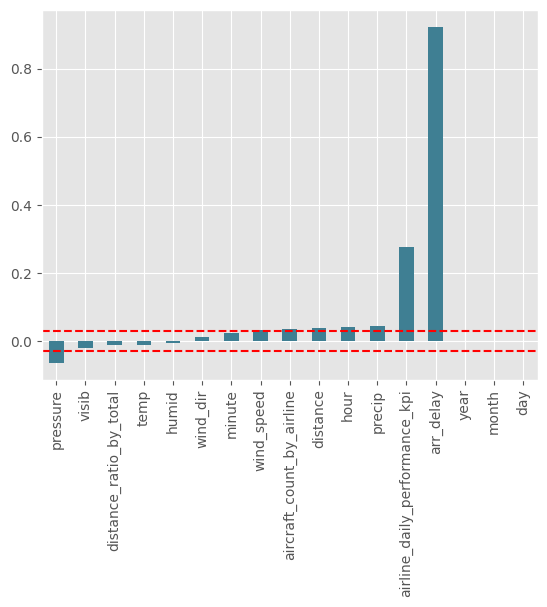

In [134]:
corrs_that_will_not_be_used = ["air_time","flight","dewp","wind_gust","daily_flight_count","dep_delay"]
tri_df["dep_delay"].drop(corrs_that_will_not_be_used).sort_values().plot(kind="bar")
plt.axhline(0.03, color ="red",linestyle ='--')
plt.axhline(-0.03, color='red',linestyle='--')
plt.show()

- Burada 0.03' den büyük değerleri almak için sorgulama yapıldı. Bu nedenle abs ile negatif değerler pozitife çevrilmiştir. Target değişkenin kaç değişken ile 0.03 üzeri korelasyonu olduğu belirlenmiştir.

In [135]:
corrs_that_will_be_drop = ["air_time","flight","dewp","wind_gust","daily_flight_count"]
cor_target = abs(tri_df["dep_delay"])
cor_target.drop(corrs_that_will_be_drop,inplace=True,axis=0)
correlated_features  = cor_target[cor_target >=0.03]
print("Toplam sayısal özellik sayısı:",len(df.select_dtypes(include=["float64","int64"]).columns))
print("Korelasyonlu özellik sayısı:",len(correlated_features))

Toplam sayısal özellik sayısı: 23
Korelasyonlu özellik sayısı: 8


# Veri Ön İşleme

**Modelleme öncesinde değişkenlere yapılacak işlemler**
1. Kullanılmayacak değişkenler belirlenmiştir.
2. Label encoding yapılacak ordinal kategorik değişkenler belirlenmiştir.
3. One hot encoding yapılacak nominal kategorik değişkenler belirlenmiştir.

**1. Kullanılmayacak değişkenlerin belirlenmesi**
- Korelasyon analizinden elde ettiğimiz değişkenler kullanılmayacaktır.
- Kardinalitesi yüksek kategorik değişkenler kullanılmayacaktır. Çok boyutluluk laneti kavramından uzaklaşmak amaçlanmıştır. Yüksek boyutlu veri overfittinge daha yatkın olmaktadir.
- Kardinalitesi yüksek sayısal değişkenler kullanılmayacaktır.
- Datetime verileri kullanılmayacaktır.
- diğer aynı şeyi ifade eden değişkenler kullanılmayacaktır.

- korelasyon analizinden elde edilen kullanılmayacak değişkenler.

In [136]:

corrs = ["air_time","flight","dewp","wind_gust","daily_flight_count"]

- kardinalitesi yüksek categorik değişkenlerde 80 üzeri kategori vardır.

In [137]:
cat_with_high_card = [col for col in df.columns if df[col].nunique() > 80 and str(df[col].dtypes) in ["category", "object"]]
cat_with_high_card

['tailnum', 'dest', 'route']

- flight korelasyon analizinde kullanılmayacak olarak tespit edilmiştir. Aynı zamanda kardinalitesi çok yüksek sayısal kategorik değişkendir.

In [138]:

df["flight"].nunique()

1099

- date değişkenleri

In [139]:
date_features = df.select_dtypes(include="datetime64").columns.to_list()
date_features

['dep_time', 'sched_dep_time', 'arr_time', 'sched_arr_time', 'date']

- Diğer değişkenler
- origin: 2 adet hava alanını ifade eder gerekli görülmedi.
- carrier: airline ın kısaltmasıdır

In [140]:
other_features = ["carrier","origin"]

**Toplam kullanılmayacak kolonlar**

In [141]:
cols_will_be_not_used = corrs + cat_with_high_card + date_features + other_features
cols_will_be_not_used

['air_time',
 'flight',
 'dewp',
 'wind_gust',
 'daily_flight_count',
 'tailnum',
 'dest',
 'route',
 'dep_time',
 'sched_dep_time',
 'arr_time',
 'sched_arr_time',
 'date',
 'carrier',
 'origin']

In [142]:
feature_columns = [col for col in df.columns if col not in cols_will_be_not_used]
df = df[feature_columns]
df.head()

,year,month,day,dep_delay,arr_delay,distance,hour,minute,airline,temp,humid,wind_dir,wind_speed,precip,pressure,visib,distance_ratio_by_total,distance_category,airline_daily_performance_kpi,aircraft_count_by_airline,dep_delay_category
0,2022,1,1,21.0,6.0,2724,0,43,American Airlines Inc.,25.0,62.50,350.0,8.05546,0.0,1020.7,10.0,0.051758,1000+ miles,17.631579,612,5.Seviye
1,2022,1,1,8.0,6.0,1024,5,5,United Air Lines Inc.,24.1,74.27,110.0,6.90468,0.0,1023.0,10.0,0.073424,1000+ miles,25.884615,525,5.Seviye
2,2022,1,1,-1.0,-14.0,1009,5,15,Southwest Airlines Co.,28.0,57.93,130.0,9.20624,0.0,1023.1,10.0,0.051165,1000+ miles,43.459459,728,3.Seviye
3,2022,1,1,-3.0,-21.0,1751,5,35,Southwest Airlines Co.,28.0,57.93,130.0,9.20624,0.0,1023.1,10.0,0.051165,1000+ miles,43.459459,728,3.Seviye
4,2022,1,1,12.0,-1.0,672,5,25,Southwest Airlines Co.,24.1,74.27,110.0,6.90468,0.0,1023.0,10.0,0.051165,500-1000 miles,43.459459,728,5.Seviye


**2. Label Encoding**
- distance_category ve dep_delay_category büyüklük ifade eden ordinal kategorik değişkenler olduğu için label encoding yapıldı. İlk önce sıralı kategorik olarak veri tipi değiştirildi. Ardından label encoding uygulandı. 

Distance Category Label Encoding İşlemi

In [143]:
df["distance_category"].value_counts()

distance_category
1000+ miles       42737
500-1000 miles    37836
0-500 miles       25041
Name: count, dtype: int64

In [144]:
categories = ["0-500 miles","500-1000 miles","1000+ miles"]
df["distance_category"] = pd.Categorical(df["distance_category"], categories=categories, ordered=True)

In [145]:
df["distance_category"].dtype

CategoricalDtype(categories=['0-500 miles', '500-1000 miles', '1000+ miles'], ordered=True, categories_dtype=object)

In [146]:
# Label encoding işlemi
df["distance_category"] = df["distance_category"].cat.codes
df["distance_category"].value_counts()

distance_category
2    42737
1    37836
0    25041
Name: count, dtype: int64

dep_delay_category Label Encoding İşlemi

In [147]:
df["dep_delay_category"].value_counts()

dep_delay_category
3.Seviye    37620
5.Seviye    27336
2.Seviye    26049
4.Seviye    11131
1.Seviye     3478
Name: count, dtype: int64

In [148]:
# 1. seviye kategori düşük gecikmeyi temsil ettiği için en çok ağırlık verilecek
categories_dep_delay = ["5.Seviye","4.Seviye","3.Seviye","2.Seviye","1.Seviye"]
df["dep_delay_category"] = pd.Categorical(df["dep_delay_category"], categories=categories_dep_delay, ordered=True)

In [149]:
df["dep_delay_category"].dtype

CategoricalDtype(categories=['5.Seviye', '4.Seviye', '3.Seviye', '2.Seviye', '1.Seviye'], ordered=True, categories_dtype=object)

In [150]:
df["dep_delay_category"] = df["dep_delay_category"].cat.codes
df["dep_delay_category"].value_counts()

dep_delay_category
2    37620
0    27336
3    26049
1    11131
4     3478
Name: count, dtype: int64

Doğru bir şekilde label encoding işlemi tamamlanmıştır.

**3. One Hot Encoding**
- airline değişkeni birbirinden farklı 12 adet havayolu firmasını temsil ettiğinden dolayı nominal kategorik değişken sınıfına girer. Bu nedenle one hot encoding uygulanmıştır.
- one hot encoding yöntemini uygularken dummy trap'dan kaçınmak önemlidir. Dummy trap, kategorik değişkenler için one hot encoding işlemi sırasında dummy değişkenler oluştururken ortaya çıkabilir ve dummy değişkenler arasında doğrusal bir bağımlılığa yol açar. Örneğin, bir değişkende bir kategori temsil edilmiyorsa, diğer tüm kategorilerin değerleri bilindiğinde bu kategori değişkeninin değeri otomatik olarak bilinir. Bu potansiyel olarak modelin doğruluğunu ve performansını azaltabilir. Dummy trapı önlemek için, drop_first parametresini kullanarak bir dummy değişkeni kaldırmak yaygın bir uygulamadır. Bu, modelin daha dengeli ve güvenilir sonuçlar üretmesine yardımcı olabilir. 
- one hot encoding sonrasında orijinal kategori değişkeni kaldırılmıştır.

In [151]:
category_one_hot = pd.get_dummies(df["airline"],drop_first=True).astype(int)
df.drop("airline", axis=1,inplace=True)
df=pd.concat([df,category_one_hot], axis=1)
df.head()

,year,month,day,dep_delay,arr_delay,distance,hour,minute,temp,humid,wind_dir,wind_speed,precip,pressure,visib,distance_ratio_by_total,distance_category,airline_daily_performance_kpi,aircraft_count_by_airline,dep_delay_category,Allegiant Air,American Airlines Inc.,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,Horizon Air,JetBlue Airways,SkyWest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,United Air Lines Inc.
0,2022,1,1,21.0,6.0,2724,0,43,25.0,62.50,350.0,8.05546,0.0,1020.7,10.0,0.051758,2,17.631579,612,0,0,1,0,0,0,0,0,0,0,0,0
1,2022,1,1,8.0,6.0,1024,5,5,24.1,74.27,110.0,6.90468,0.0,1023.0,10.0,0.073424,2,25.884615,525,0,0,0,0,0,0,0,0,0,0,0,1
2,2022,1,1,-1.0,-14.0,1009,5,15,28.0,57.93,130.0,9.20624,0.0,1023.1,10.0,0.051165,2,43.459459,728,2,0,0,0,0,0,0,0,0,1,0,0
3,2022,1,1,-3.0,-21.0,1751,5,35,28.0,57.93,130.0,9.20624,0.0,1023.1,10.0,0.051165,2,43.459459,728,2,0,0,0,0,0,0,0,0,1,0,0
4,2022,1,1,12.0,-1.0,672,5,25,24.1,74.27,110.0,6.90468,0.0,1023.0,10.0,0.051165,1,43.459459,728,0,0,0,0,0,0,0,0,0,1,0,0


- Böylelikle makine öğrenimi modelinde kullanılmak üzere veri setinin ön işleme süreçleri tamamlanmıştır.

# Model Oluşturma ve Değerlendirme

- Hedef değişken olarak dep_delay sürekli değişkeninin tahmin edilmesi bir regresyon problemidir.
- Model oluşturmada Occam's Razor prensibi kullanılmıştır ilk önce basit bir model oluşturup. Daha sonra karmaşık model oluşturulup karşılaştırma yapılacaktır.
- Bunun için ilk model olarak linear regresyonu seçilmiştir. Özellikle hedef değişken ile bağımsız değişkenler arasında doğrusal korelasyonlar varsa iyi performans gösterir. Modele beslenecek veriler çarpıksa verilerin ölçeklenmesi performansını artırır.
- Karşılaştırma modeli olarak daha karmaşık yapıda olan XGBoostRegressor seçilmiştir. Bu model boosting topluluk öğrenme yöntemlerinden biridir. Temel öğrenicisi karar ağaçlarıdır. Birçok zayıf karar ağacının birleşip birbirlerinin hatalarından öğrenip gelişen bir yapıya sahiptir. Karmaşık ilişkileri yakalamada sıklıkla kullanılan bir modeldir. Ölçekleme gerektirmez. Ayrıca hızlı çalışmaktadır.
- Kullanılacak metrikler olarak Root Mean Squared Error(RMSE) ve R2 score seçilmiştir. 
- RMSE secilmesinin nedeni elde edilen sonuç tahmin yapacağımız değişkenin cinsinden olur.Bu sayede daha anlaşılabilir karşılaştırma yapabiliriz. Tahmin sonrası gerçek değerler ile tahmin edilen değerler arasındaki farkın karesel toplamının ortalamasının kareköküdür. Örneğin RMSE sonucu 10 dakika çıkmışa 10 dakika hata ile tahmin ettik diyebiliriz. Değer ne kadar düşük olursa o kadar iyidir. RMSE ayrıca büyük hataları karşı daha fazla hassasiyet gösterir. Burda metrik olarak Mean Absolute Error da seçilebilirdi ama MAE hataları olduğu gibi kabul eder. Örneğin iki tahminden biri 1 diğeri 7, MAE kullanırsak 1+7/2 =4 çıkar. Ama RMSE kullanırsak 1 + 49 = 50, karekökü alındığında yaklaşık 7 çıkar yani bu sayede hata farklarını fazla cezalandırıp etkisini ortaya koymuş oluruz.
- R2 score kullanmamın nedeni r2 regresyon modelinin veriye ne kadar iyi uyduğunu ölçen bir istatistiksel ölçüdür. R-kare, bağımsız değişkenlerin bağımlı değişken üzerindeki varyansını açıklama yüzdesini ifade eder. Yani, R-kare değeri, bağımsız değişkenlerin bağımlı değişkeni ne kadar iyi açıkladığını gösterir. R-kare değeri, 0 ile 1 arasında bir değer alır. 1'e yaklaşan R-kare değeri, modelin veriye mükemmel bir şekilde uyduğunu ve bağımsız değişkenlerin bağımlı değişken üzerindeki varyansın tamamını açıkladığını gösterir.
  


**Model eğitim ve değerlendirme için kullanılacak fonksiyonun tanımlanması**
- Tüm model eğitimi ve değerlendirme süreci, işleri kolay ve hatasız hale getirmek, zaman kazanmak, denemeler yapmak için fonksiyona dönüştürülmüştür. Bu fonksiyon, modeli, bölünmüş verileri, çapraz doğrulama stratejisini, model değerlendirmede kullanılacak metriği  parametre olarak alır ve eğitilmiş modeli, eğitim ve doğrulama skorlarını içeren dataframe'i, son test skorunu ve test seti üzerindeki tahminleri döndürür. Plot parametresi aynı zamanda True olarak belirtilirse eğitim ve doğrulama sonuçlarını çizer. Eğitim verilerine çapraz doğrulama uygulamak, model değerlendirme aşamasında sıklıkla tercih edilen bir yöntemdir. Bu sayede modelin eğitim, doğrulama ve test seti üzerindeki sonuçlarını karşılaştırarak aşırı uyum ve yetersiz uyum durumlarını daha kolay gözlemleyebilir ve hiperparametreleri bu sonuçlara göre ayarlayabiliriz.

In [152]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, score_func, cv_type, plot=True, use_rmse=False):
    """
    Bu fonksiyon, bir modelin performansını değerlendirmek için çapraz doğrulama yöntemini kullanır.
    Eğitim skoru, validasyon skoru ve test skorunu ayrı ayrı hesaplayarak karşılaştırma yapılmasını sağlar. 
    İlk önce çapraz doğrulama yapar sonra modeli baştan bütün eğitim seti ile eğiterek test scoru hesaplar.
    Bu sayede model performansı daha iyi değerlendirilip overfitting veya underfitting gibi sorunlar tespit edilebilir.

    Parametreler:
    model : eğitilecek model.
    X_train : pandas.DataFrame, bölünmüş eğitim veri kümesi.
    y_train : pandas.Series, eğitim veri kümesinin hedef değişkeni.
    X_test : pandas.DataFrame, bölünmüş test veri kümesi.
    y_test : pandas.Series, test veri kümesinin hedef değişkeni.
    score_func : fonksiyon, değerlendirme metriği. Örneğin, mean_squared_error, mean_absolude_error, vb.
    cv_type : çapraz doğrulama stratejisi. Örneğin, KFold, StratifiedKFold, vb.
    plot : bool, opsiyonel (varsayılan=True) Eğitim ve doğrulama skorlarını True ise, çizdirir.
    use_rmse: bool, opsiyonel (varsayılan=False) Eğer metric fonksiyonu mean_squared_error olursa True yapılarak Root Mean Squared Error hesaplanır.

    Returns:
    model : eğitilmiş model.
    final_test_score : float, test setinde elde edilen metrik skor.
    scores_df : pandas.DataFrame, hesaplanmış eğitim ve doğrulama skorlarını içeren dataframe.
    y_pred_test: pandas.Series, test setindeki tahminler.
    """
    
    # skor listelerinin tanımlanması.
    train_scores = []
    validation_scores = []
    score_per_fold = []
    fold = 1

    # overfitting veya underfitting tespit etmek için çapraz doğrulama aşaması.
    for train_index, test_index in cv_type.split(X_train, y_train):
        X_train_cv, X_validation_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_validation_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        # modelin çapraz doğrulama eğitim setine fit edilmesi.
        model.fit(X_train_cv, y_train_cv)
        y_pred_train = model.predict(X_train_cv)
        y_pred_validation = model.predict(X_validation_cv)
        
        # eğitim skoru hesaplanması.
        train_score = score_func(y_train_cv, y_pred_train)
        # validasyon skoru hesaplanması.
        validation_score = score_func(y_validation_cv, y_pred_validation)

       
       #Eğer mean_squared_error skor fonksiyonu gelirse use_rmse=True ise RMSE hesaplanır.
        if use_rmse and score_func.__name__ == "mean_squared_error":
            train_score = np.sqrt(train_score)
            validation_score = np.sqrt(validation_score)
            # çıktıda yazılacak fonksiyon ismi
            score_name = "root_mean_squared_error"
        else:
            train_score = train_score
            validation_score = validation_score
            # çıktıda yazılacak fonksiyon ismi
            score_name = score_func.__name__
        

        # skorların eğitim ve validasyon listelerine eklemesi.
        train_scores.append(train_score)
        validation_scores.append(validation_score)

        # fold başına skorların yazdırılması.
        print(f"{fold}. Fold train_{score_name}: {train_score:.2f}")
        print(f"{fold}. Fold validasyon_{score_name}: {validation_score:.2f}")

        fold += 1
        # çizim aşaması için katman listesi
        score_per_fold.append(fold)

    print("Çapraz doğrulama aşaması tamamlandı! Model eğitimine başlanıyor...")

    # Çapraz doğrulama aşaması tamamlandıktan sonra. Model tüm eğitim seti ile tekrar eğitilir.
    model.fit(X_train, y_train)
    print("*******************************************")
    print("Model eğitim aşaması tamamlandı!")
    print("*******************************************")

    # test seti üzerinden tahmin yapılması.
    y_pred_test = model.predict(X_test)
    
    # test setindeki skorun hesaplanması. Eğer mean_squared_error skor fonksiyonu gelirse use_rmse=True ise RMSE hesaplanır.
    if use_rmse and score_func.__name__ == "mean_squared_error":
        final_test_score = np.sqrt(score_func(y_test, y_pred_test))
        score_name = "root_mean_squared_error"
    else:
        final_test_score = score_func(y_test, y_pred_test)
        score_name = score_func.__name__

    # skorları kaydeden sözlük tanımlaması.
    scores_dict = {
    "fold": range(1, len(score_per_fold) + 1),
    f"train_{score_name}": train_scores,
    f"validation_{score_name}": validation_scores
    }

    # çizim için dataframe oluşturulması.
    scores_df = pd.DataFrame(scores_dict)

    # Sonuçların yazdırılması.
    print(f"Ortalama train_{score_name} sonucu: {np.mean(train_scores):.2f}")
    print(f"Ortalama validation_{score_name} sonucu: {np.mean(validation_scores):.2f}")
    print(f"Test_{score_name} sonucu: {final_test_score:.2f}")
    print("*******************************************")

    # Katman başına eğitim ve validasyon skorlarını line grafik olarak çizdirir.
    if plot:
        sns.lineplot(data=scores_df, x="fold", y=f"train_{score_name}", marker="o", label=f"train_{score_name}")
        sns.lineplot(data=scores_df, x="fold", y=f"validation_{score_name}", marker="v", label=f"validation_{score_name}")
        plt.xlabel("Katman")
        plt.ylabel(f"{score_name}")
        plt.title(f"Her katmanın {score_name} skoru")
        plt.legend()
        plt.show()

    return  model, final_test_score, scores_df, y_pred_test


**Verilerin Eğitim ve Test Olarak ayrılması**
- Model aşamasında metriklerimizi hesaplamak için veri setini eğitim ve test diye bölmek yaygın bir uygulamadır. Burada verinin %20'si test seti için ayrılmıştır.

In [153]:
target = "dep_delay"
X = df.drop(target,axis=1)
y= df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [154]:
X_train.shape

(84491, 30)

In [155]:
y_train.shape

(84491,)

In [156]:
X_test.shape

(21123, 30)

In [157]:
y_test.shape

(21123,)

**Linear Regression Modeli**
- Modelin daha iyi performans göstermesi için yüksek derecede sağa çarpık verilerin ölçeklendirilmesi gerekebilir. Bunun için pipeline içerisinde RobustScaler kullanılmıştır. 
- RobustScaler, aykırı değerlerin etkisini azaltmak için medyan ve yüzdelik aralıkları kullanarak çalışır. Çarpık değişkenlerin olduğu veri setlerinde iyi performans gösterebilir.


1. Fold train_root_mean_squared_error: 10.40
1. Fold validasyon_root_mean_squared_error: 10.60
2. Fold train_root_mean_squared_error: 10.40
2. Fold validasyon_root_mean_squared_error: 10.63
3. Fold train_root_mean_squared_error: 10.44
3. Fold validasyon_root_mean_squared_error: 10.29
4. Fold train_root_mean_squared_error: 10.43
4. Fold validasyon_root_mean_squared_error: 10.33
5. Fold train_root_mean_squared_error: 10.40
5. Fold validasyon_root_mean_squared_error: 10.60
6. Fold train_root_mean_squared_error: 10.39
6. Fold validasyon_root_mean_squared_error: 10.75
7. Fold train_root_mean_squared_error: 10.47
7. Fold validasyon_root_mean_squared_error: 10.00
8. Fold train_root_mean_squared_error: 10.46
8. Fold validasyon_root_mean_squared_error: 10.07
9. Fold train_root_mean_squared_error: 10.43
9. Fold validasyon_root_mean_squared_error: 10.35
10. Fold train_root_mean_squared_error: 10.40
10. Fold validasyon_root_mean_squared_error: 10.64
Çapraz doğrulama aşaması tamamlandı! Model eğiti

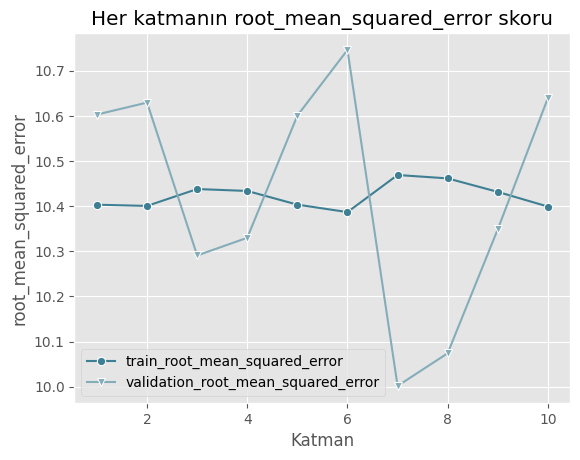

In [158]:
# Metrik RMSE

lr = LinearRegression()

lr_pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("regressor", lr)
])

kf = KFold(n_splits=10,shuffle=True,random_state=42)
lr_model, lr_final_test_rmse_score, lr_rmse_scores_df,lr_y_pred_test = train_and_evaluate_model(lr_pipeline, X_train, y_train, X_test, y_test, mean_squared_error, kf, plot=True, use_rmse=True)

1. Fold train_r2_score: 0.87
1. Fold validasyon_r2_score: 0.86
2. Fold train_r2_score: 0.87
2. Fold validasyon_r2_score: 0.89
3. Fold train_r2_score: 0.87
3. Fold validasyon_r2_score: 0.87
4. Fold train_r2_score: 0.87
4. Fold validasyon_r2_score: 0.87
5. Fold train_r2_score: 0.87
5. Fold validasyon_r2_score: 0.88
6. Fold train_r2_score: 0.87
6. Fold validasyon_r2_score: 0.88
7. Fold train_r2_score: 0.87
7. Fold validasyon_r2_score: 0.87
8. Fold train_r2_score: 0.87
8. Fold validasyon_r2_score: 0.86
9. Fold train_r2_score: 0.87
9. Fold validasyon_r2_score: 0.86
10. Fold train_r2_score: 0.87
10. Fold validasyon_r2_score: 0.87
Çapraz doğrulama aşaması tamamlandı! Model eğitimine başlanıyor...
*******************************************
Model eğitim aşaması tamamlandı!
*******************************************
Ortalama train_r2_score sonucu: 0.87
Ortalama validation_r2_score sonucu: 0.87
Test_r2_score sonucu: 0.88
*******************************************


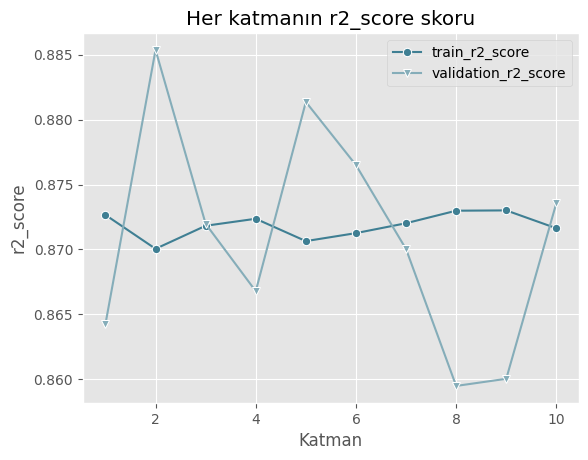

In [159]:
# Metrik R2

lr = LinearRegression()

lr_pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("regressor", lr)
])

kf = KFold(n_splits=10,shuffle=True,random_state=42)
_ , lr_final_test_r2_score, lr_r2_scores_df,lr_y_pred_test = train_and_evaluate_model(lr_pipeline, X_train, y_train, X_test, y_test, r2_score, kf, plot=True, use_rmse=False)

**Linear Regression Özellik Seçimi**
- Pipeline içerisinden named_steps ile modele erişip her değişkene ne kadar katsayı verdiği alınıp değişkenlere göre görselleştirilmiştir.
- Korelasyon analizindede belirlediğimiz gibi arr_delayin etkisi görülmektedir. Ayrıca yağışı ifade eden precip(yağışlar)'in etkisinin yüksek olduğunu görüyoruz.
- Düşük gecikme süresine yüksek puan verdiğimiz dep_delay_category negatif değer almıştır.

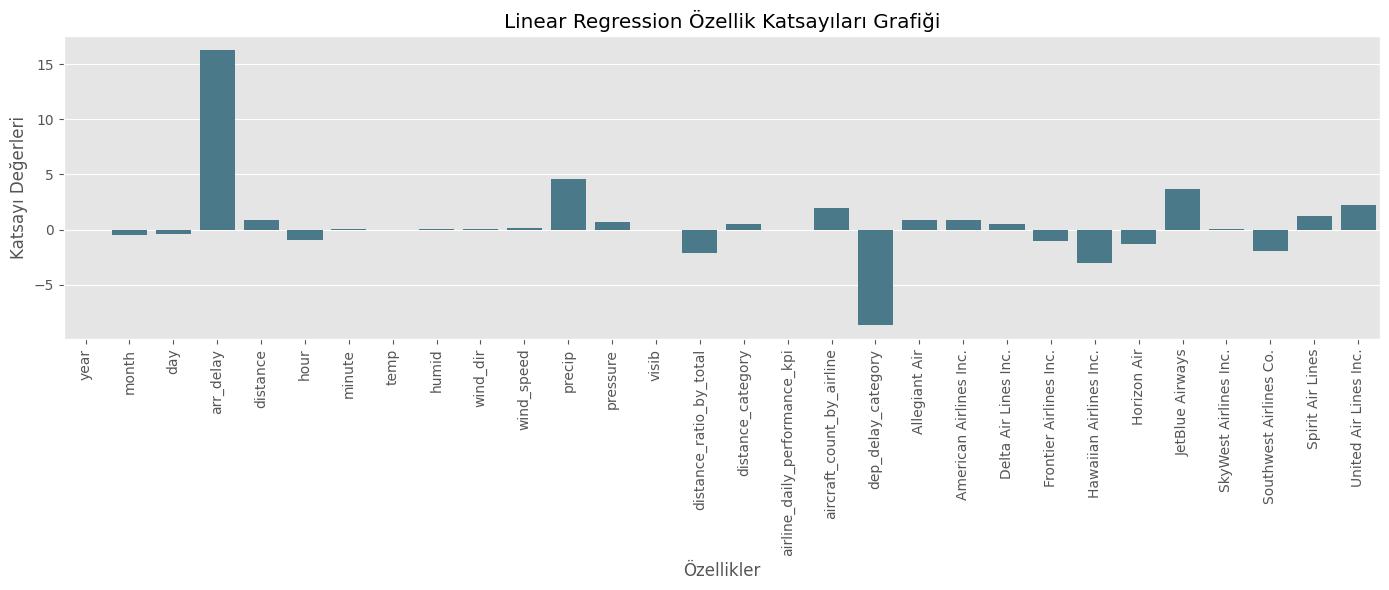

In [160]:
coef_values = lr_model.named_steps["regressor"].coef_
columns = X_train.columns
plt.figure(figsize=(14,6))
sns.barplot(x=columns, y=coef_values)
plt.xlabel("Özellikler")
plt.ylabel("Katsayı Değerleri")
plt.title("Linear Regression Özellik Katsayıları Grafiği")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**XgBoostRegressor Modeli**
- Model ağaç tabanlı olduğundan karmaşık ve çarpık verilerde iyi performans gösterir bu nedenle ölçekleme uygulanmamıştır.

**XGBoostRegressor Hiperparametre ayarlaması**
- Hiperparametre ayarlamada en etkili yöntem Grid Search kullanmaktır. Bütün parametre kombinasyonlarını tek tek dener ve en iyi sonuç elde edilir. Fakat hesaplama süresi çok uzundur. Buna alternatif olarak Randomized Search kullanılabilir oda parametreleri rastgele seçer her deneme birbirinden bağımsızdır. Randomized search e en iyi alternatif bayesian yöntemdir. Bu yöntem yeni denemeler yaparken her denemenin sonucuna göre istatistiksel dağılımları kullanarak seçim yapılır. Bu nedenle bu problemde bayesian hiperparametre ayarlama metodu tercih edilmiştir.
- Bayesyen hiperparametre ayarlama, makine öğrenimi modellerindeki hiperparametreleri optimize etmek için bayesyen istatistiklerini kullanır. 
Bu yöntem, en iyi hiperparametre değerlerini tahmin etmek için bir olasılık dağılımını günceller ve modelin performansını artırmayı amaçlar.
- Her adımda, bir önceki denemeden elde edilen sonuçları kullanarak, yeni denemeler için en umut verici parametre kombinasyonlarını seçer. Bu, daha akıllı bir arama stratejisi sağlar.
- Parametre aralıklarını ve önceki denemelerden gelen bilgiyi dikkate alarak, daha verimli bir şekilde arama yapabilir.
- Genel bir bakış sağlamak için xgboostun performansa en çok etki eden parametrelerini seçmek amaçlanmıştır.
- learning rate, gradyan iniş yöntemindeki adımı ifade eder.
- n_estimators, kullanılacak ağaç sayısıdır.
- max_depth, ne kadar derine inileceğini başka bir deyişle kaç düğümden oluşacağını belirler.
- booster, temel öğrenici ağaçmı linearmı olduğu belirlenir.
- seed, modelin ranstgele sayı üretmesinde başlangıç değerini belirler.
- colsample_bytree, her ağaç oluşturulurken kullanılacak özelliklerin yüzde değerini ifade eder. örneğin 0.8 değeri özelliklerin %80 modelde kullanılacak demektir.
- alpha, l1(lasso) regularizasyonu ifade eder. Değerin yüksek olması çok fazla regularizasyon uygulayıp modeli basitleştirir.
- Fonksiyonda bunları baz alarak 80 deneme sonrası sonuçlar alınmıştır.
- İşlem yaklaşık 12 dakika sürmüştür.

In [161]:
# parametre uzayının tanımlanması
space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.04), np.log(0.1)),  # Öğrenme oranı, logaritmik dağılım kullanılarak belirlenir.
    "n_estimators": hp.quniform("n_estimators", 50, 300, 1),  # Ağaç sayısı, 100 ile 350 arasında 10'ar artırılır.
    "max_depth": hp.quniform("max_depth", 1, 10, 1),  # Ağaçların maksimum derinliği, 3 ile 15 arasında 1 er artırılır.
    'booster': hp.choice('booster', ['gbtree', 'gblinear']), # temel öğrenici linear yada ağaç olsun.
    'seed': 0,
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),  # Her ağaç için seçilecek özellik  oranı, 0.5 ile 1 arasında uniform dağılım kullanılarak belirlenir.
    'alpha': hp.uniform('alpha', 0, 1)  # L1 (lasso) regularizasyon, 0 ile 1 arasında uniform dağılım kullanılarak belirlenir.
}

# hiperparametre setinin optimizasyonunun yapılması, model oluşturulup scorlar hesaplanır.
def objective(params,X,y):
    xg_reg = XGBRegressor(
        n_estimators=int(params["n_estimators"]),
        max_depth=int(params["max_depth"]),
        learning_rate=params["learning_rate"],
        seed=params['seed'],
        booster=params['booster'],
        colsample_bytree=params['colsample_bytree'], 
        alpha=params['alpha'] 
    )
    
    kf = KFold(n_splits=10,shuffle=True,random_state=42)
    rmse_scores = []
    # Çapraz doğrulama ve skor hesaplama aşaması
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        xg_reg.fit(X_train, y_train)
        predictions = xg_reg.predict(X_test)

        mse_score = mean_squared_error(y_test, predictions)
        rmse_score = np.sqrt(mse_score)
        rmse_scores.append(rmse_score)

    average_mae = sum(rmse_scores) / len(rmse_scores)
    return average_mae

# denemelerin sonuçlarının izlenmesi
trials = Trials()
# Hiperparametre optimizasyonunu gerçekleştiren ana fonksiyondur. Belirtilen objective fonksiyonunu ve space'i kullanarak, en iyi hiperparametre setini bulmaya çalışır. 
best = fmin(fn=lambda params:objective(params,X=X,y=y), space=space, algo=tpe.suggest, max_evals=80, trials=trials)

print("En iyi hiperparametreler:", best)
print("En iyi skor (MAE):", trials.best_trial["result"]["loss"])

100%|██████████| 80/80 [12:50<00:00,  9.63s/trial, best loss: 8.265627020734955]
En iyi hiperparametreler: {'alpha': 0.5272963427971633, 'booster': 0, 'colsample_bytree': 0.9419513863351456, 'learning_rate': 0.060543055012394174, 'max_depth': 3.0, 'n_estimators': 258.0}
En iyi skor (MAE): 8.265627020734955


**Bayesian çıktısı alındıktan sonra train_and_evaluate_model fonksiyonu kullanılarak gelen değerlere göre tekrar manuel ayarlama yapılmıştır.**

In [162]:
bayesian_xgb_params = {'alpha': 0.7, 'booster': 'gbtree', 'colsample_bytree': 0.9, 'learning_rate': 0.09, 'max_depth': 2, 'n_estimators': 250}

In [163]:
# parametrelerin kontrolü
# n_jobs=-1 işlemcinin bütün çekirdeklerini kullan demektir.
xgb = XGBRegressor(**bayesian_xgb_params,n_jobs=-1)
xgb.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.9,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.09,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 2,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 250,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'alpha': 0.7}

1. Fold train_root_mean_squared_error: 8.19
1. Fold validasyon_root_mean_squared_error: 8.70


2. Fold train_root_mean_squared_error: 7.92
2. Fold validasyon_root_mean_squared_error: 11.18
3. Fold train_root_mean_squared_error: 8.26
3. Fold validasyon_root_mean_squared_error: 7.68
4. Fold train_root_mean_squared_error: 8.28
4. Fold validasyon_root_mean_squared_error: 7.46
5. Fold train_root_mean_squared_error: 8.10
5. Fold validasyon_root_mean_squared_error: 9.77
6. Fold train_root_mean_squared_error: 7.95
6. Fold validasyon_root_mean_squared_error: 8.34
7. Fold train_root_mean_squared_error: 8.22
7. Fold validasyon_root_mean_squared_error: 7.84
8. Fold train_root_mean_squared_error: 8.26
8. Fold validasyon_root_mean_squared_error: 7.38
9. Fold train_root_mean_squared_error: 8.27
9. Fold validasyon_root_mean_squared_error: 7.94
10. Fold train_root_mean_squared_error: 8.15
10. Fold validasyon_root_mean_squared_error: 9.01
Çapraz doğrulama aşaması tamamlandı! Model eğitimine başlanıyor...
*******************************************
Model eğitim aşaması tamamlandı!
****************

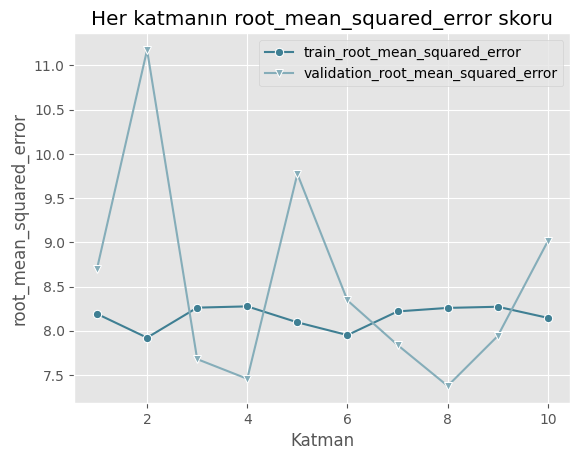

In [164]:
# Metric RMSE

kf = KFold(n_splits=10,shuffle=True,random_state=42)
xgb_model, xgb_final_test_rmse_score, xgb_rmse_scores_df,xgb_y_pred_test = train_and_evaluate_model(xgb, X_train, y_train, X_test, y_test, mean_squared_error, kf, plot=True, use_rmse=True)

1. Fold train_r2_score: 0.92
1. Fold validasyon_r2_score: 0.91
2. Fold train_r2_score: 0.92
2. Fold validasyon_r2_score: 0.87
3. Fold train_r2_score: 0.92
3. Fold validasyon_r2_score: 0.93
4. Fold train_r2_score: 0.92
4. Fold validasyon_r2_score: 0.93
5. Fold train_r2_score: 0.92
5. Fold validasyon_r2_score: 0.90
6. Fold train_r2_score: 0.92
6. Fold validasyon_r2_score: 0.93
7. Fold train_r2_score: 0.92
7. Fold validasyon_r2_score: 0.92
8. Fold train_r2_score: 0.92
8. Fold validasyon_r2_score: 0.92
9. Fold train_r2_score: 0.92
9. Fold validasyon_r2_score: 0.92
10. Fold train_r2_score: 0.92
10. Fold validasyon_r2_score: 0.91
Çapraz doğrulama aşaması tamamlandı! Model eğitimine başlanıyor...
*******************************************
Model eğitim aşaması tamamlandı!
*******************************************
Ortalama train_r2_score sonucu: 0.92
Ortalama validation_r2_score sonucu: 0.91
Test_r2_score sonucu: 0.92
*******************************************


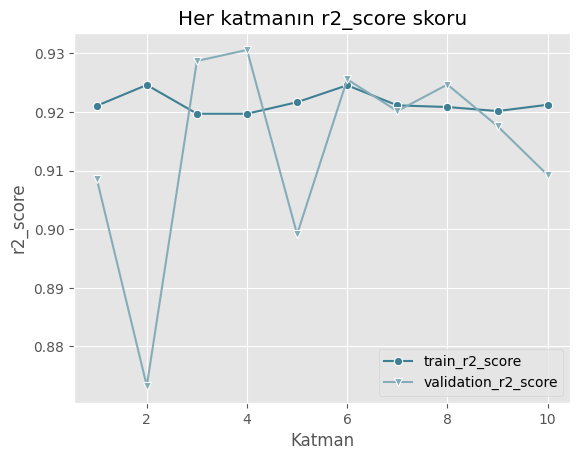

In [165]:
# Metrik R2

kf = KFold(n_splits=10,shuffle=True,random_state=42)
xgb_model, xgb_final_test_r2_score, xgb_r2_scores_df,xgb_y_pred_test = train_and_evaluate_model(xgb, X_train, y_train, X_test, y_test, r2_score, kf, plot=True, use_rmse=True)

**XGBoost Regressor Regression Özellik Seçimi**
- Mode içerisinden feature_importances_ ile katsayılara erişilmiş ve görselleştirilmiştir.
- Yine göze çarpan özelliklerin arr_delay, hour, airline_daily_performance_kpi, aircraft_count_by_airline_ dep_delay_category olduğu görülmektedir.

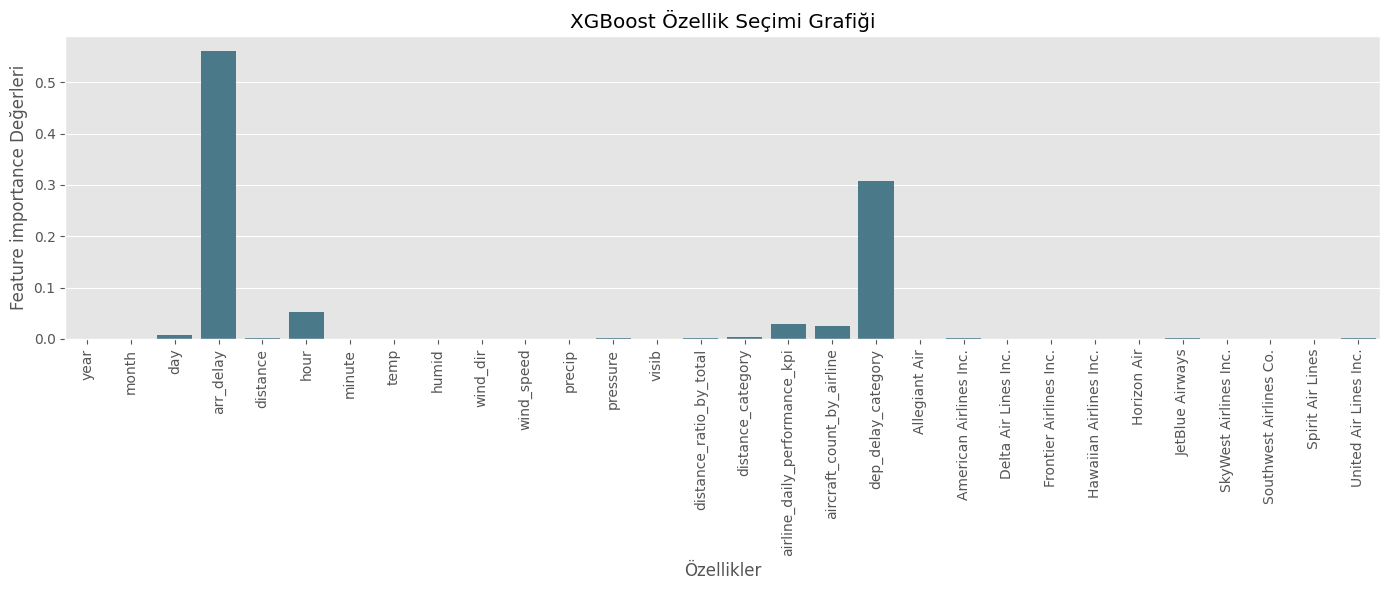

In [166]:
feature_importances = xgb_model.feature_importances_
columns = X_train.columns
plt.figure(figsize=(14,6))
sns.barplot(x=columns, y=feature_importances)
plt.xlabel("Özellikler")
plt.ylabel("Feature importance Değerleri")
plt.title("XGBoost Özellik Seçimi Grafiği")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Modellerin Karşılaştırılması**
- Linear regresyon modeli gecikmeleri 10.49 dakika hata payı (RMSE) ile tahmin etmiştir. R2 0.88 çıkmasıda modelin veriye çok iyi bir şekilde uyduğunu gösterir. Linear regresyon modeli bu veri setinde iyi performans göstermiştir diyebiliriz. 2 metrik içinde eğitim, doğrulama ve test verilerinin birbirine yakın olmasıda modelin dengeli ve genelleştirilebilir olduğunu herhangi bir overfitting underfitting durumu olmadığını gösterebilir.
  
- XGBoost Regressor modeli gecikmeleri 8.77 dakika hata payı (RMSE) ile tahmin etmiştir. R2 0.92 çıkmasıda modelin veriye mükemmele yakın bir şekilde uyduğunu gösterir. XGBoost Regressor modeli bu veri setinde çok iyi performans göstermiştir. 2 metrik içinde eğitim, doğrulama ve test verilerini incelediğimizde yine dengeli görünmektedir. Test sonucunun eğitim sonucundan biraz yüksek olması beklenen bir durumdur. Xgboostun parametrelerinin ayarlanmasına biraz daha vakit harcanıp daha da iyi sonuçlar elde edilebilir.
- Modellerin metriklere göre karşılaştırılması görseli aşağıda sunulmuştur.


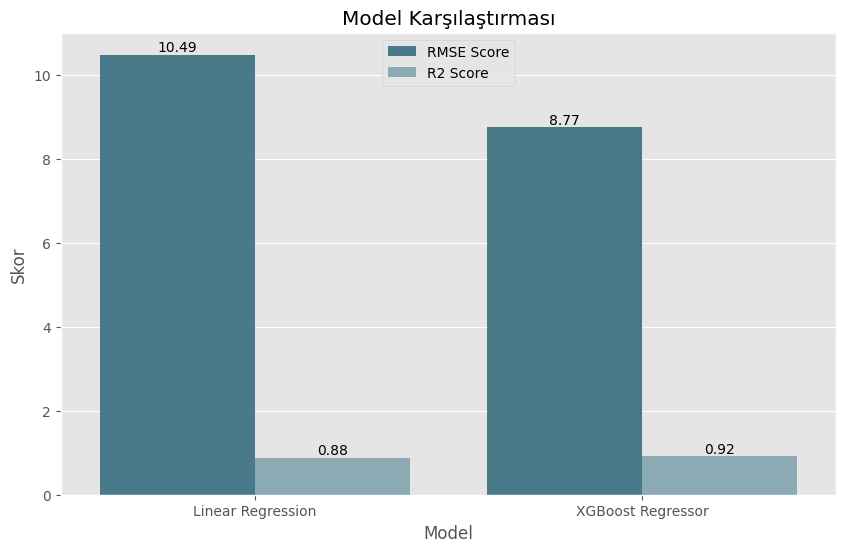

In [167]:
scores_data = {
    "Model": ["Linear Regression"] * 2 + ["XGBoost Regressor"] * 2,
    "Metrik": ["RMSE Score", "R2 Score"] * 2,
    "Skor": [lr_final_test_rmse_score, lr_final_test_r2_score, xgb_final_test_rmse_score, xgb_final_test_r2_score]
}
scores_df = pd.DataFrame(scores_data)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Model", y="Skor", hue="Metrik", data=scores_df)
for container in ax.containers:
    ax.bar_label(container, fmt='%0.2f', label_type="edge")
plt.title("Model Karşılaştırması")
plt.ylabel("Skor")
plt.xlabel("Model")
plt.legend(loc="upper center")
plt.show()

**İki modelin seçtiği özelliklerin aynı ölçekteki karşılaştırılmalı görünümü**
- Burada iki modelin seçtiği özellikleri aynı ölçekte göstermek için minmaxscaler kullanılmıştır. Bu sayede karşılaştırmalı bir grafik elde etmek amaçlanmıştır.
- iki modelin seçtiği özellikler ve kolon adlarından önce sözlük sonra dataframe oluşturulup görselleştirilmiştir.
- Linear regression arr_delay, precip(yağışlar) değişkenlerine pozitif, dep_delay_category değişkenine negatif önem vermiştir.
- Xgboost regressor arr_delay, hour, airline_daily_performance_kpi, aircraft_count_by_airline_ dep_delay_category değişkenlerine  önem vermiştir.
- Genellikle ağaç tabanlı feature_importances değerleri pozitif çıkar. Bu değerler etkinin büyüklüğünü gösterir. Bu nedenle pozitif değere sahip olmalıdır.
- Ağaç tabanlı modellerin güzel bir özelliği de özellik seçimi yapmasıdır. Önemli olan özellikler tahminde daha çok rol oynar.

In [168]:
feature_dict = {"Özellikler":X_train.columns,"Linear Regression Özellikleri": coef_values, "XGBoost Regressor Özellikleri": feature_importances}
models_features_df = pd.DataFrame(feature_dict)
models_features_df.set_index("Özellikler",inplace=True)

scaler = MinMaxScaler()
models_features_df_scaled =scaler.fit_transform(models_features_df)
df_scaled_features = pd.DataFrame(models_features_df_scaled, columns=models_features_df.columns, index=models_features_df.index)

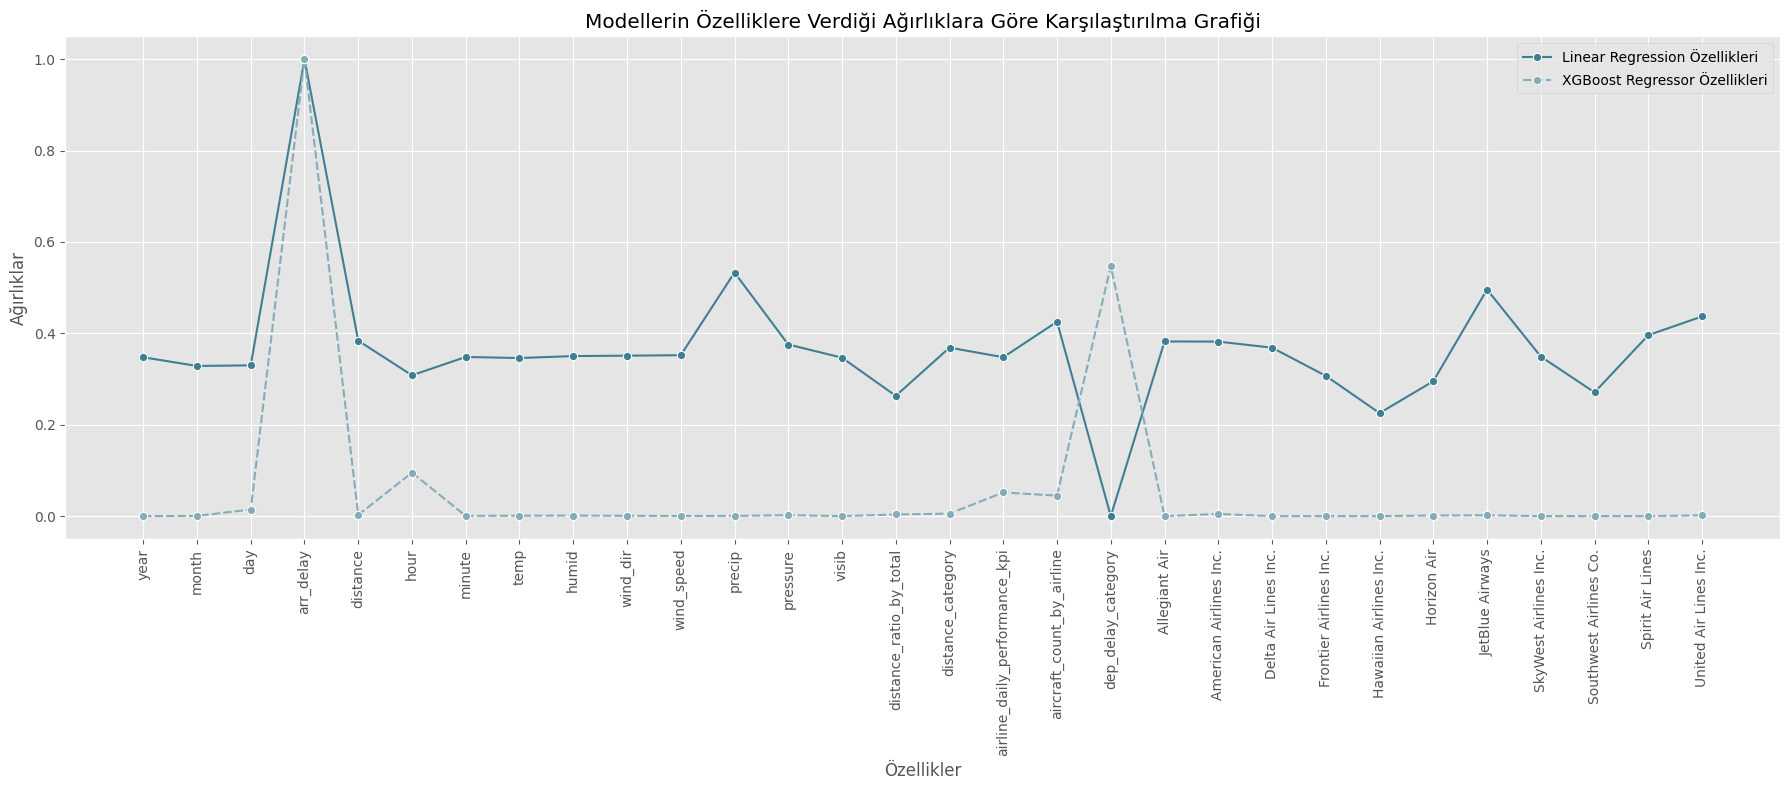

In [169]:
plt.figure(figsize=(18, 8))
sns.lineplot(df_scaled_features, markers="o")
plt.title("Modellerin Özelliklere Verdiği Ağırlıklara Göre Karşılaştırılma Grafiği")
plt.xlabel("Özellikler")
plt.ylabel("Ağırlıklar")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

# Sonuç ve Öneriler

- **Gecikme süreleri tahmin problemimiz için gerekli keşifsel veri analizi ve veri ön işleme aşamaları tamamlanıp 2 adet model oluşturulmuştur. Karşılaştırma metriği olarak RMSE ve R2 kullanılmıştır. Yapılan analizler neticesinde XGBoost Regressor modeli tercih edilmiş, uçuş gecikmeleri R2 metriğinin 0.92 sonuç vermesi güvenilirliğine de dayanarak 8.77 dakika hata payıyla hesaplanmıştır.**
  
**Daha iyi sonuçlar elde etmek için;**
- **Değişkenlere tek tek aykırı değer analizi yapılabilir ve aykırı değerler baskılanabilir.**
-  **Daha fazla özellik mühendisliği yapılıp yeni özellikler eklenebilir. Örneğin, Uçakların yolcu sayıları bulunabilir, müşteri memnuniyeti puanlamaları incelenebilir, müşteri yorumlarına sentiment analizi yapılıp olumlu ise 1 olumsuz ise 0 şeklinde modele eklenebilir, müşteri hizmetlerine gelen aramalara bakılabilir, şirketlerin borsadaki hisse değerlerine bakılabilir, şirketlerin sahip olduğu uçakların yeniliğine eskiliğine bakılabilir, kalkış ve iniş yapılan hava alanlarının olduğu bölgelerin kültürel, ekonomik yapısı incelenebilir, yolcular gelir durumlarına, eğitim durumlarına göre gruplanarak hangi grubun hangi havayollarını tercih ettiğin incelenebilir vs.** 
-  **Model yeni verilerle test edilip performansı izlenmelidir.**